# Fake News - Fake Watch
## Yael Saffron, Yoav Ast, Omri Shtayer
#### Our Project - Explaination:
1. Data Exploration & Manipulation
    1.1 Fake News Database
        1.1.1 Cleaning Data without Text
        1.1.2 Adding more Data to our Table
            1.1.1.1 Adding NewsPaper Articles - BBC
            1.1.1.2 Fake,Bullshit,conspiracy DataBase - Adding more fake news
                1.1.1.2.1 Cleaning The Data
            1.1.1.3 Adding known real articles from a news database
        1.1.3 Adding Head & Body Length and the relation between them
        1.1.4 Categorizing the Sites
        1.1.5 Cleaning our Textual Data
            1.1.5.1 Cleaning our Data
        1.1.6 Checking for most common fake words
        1.1.7 Checking for Grammer !, ? , %  **a possibility of creating fake news dictionary
        1.1.8 Handling non-normal distribution
        1.1.9 WordCloud Picture
2. Data Preprocessing
        2.1 Running Google's Sentiment Analysis
        2.2 Exploring Train Data
        2.3 Plots
        2.4 Wrapping up - Pickle
3. Reading Our Pickle Data
4. Modeling
    4.1 GridSearch
    4.2 Smal Tree
    4.3 Large Tree
    4.4 Random Forest
        4.4.1 Random Forest with 0.5 Threshold
        4.4.2 Random Forst with 0.3 Threshold
        4.4.3 Trying RF on Train Data for Comparison
    4.5 GBM
5. B2B Model - Helping Trump

# 1. Data Exploration & Manipulation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns

import re
import nltk
import os
import sys
import tarfile

from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from os import path
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
nltk.download('stopwords')

from sklearn import ensemble 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from google.cloud import speech
from google.cloud import language

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shtay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_fake = pd.read_csv('Data/fakenews.csv')
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
URLs        4009 non-null object
Headline    4009 non-null object
Body        3988 non-null object
Label       4009 non-null int64
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


## 1.1 Fake News Database

### 1.1.1 Cleaning Data without Text
Rows with no value in Body are incorrect - we drop those rows

In [3]:
df_fake = df_fake.dropna()
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3988 entries, 0 to 4008
Data columns (total 4 columns):
URLs        3988 non-null object
Headline    3988 non-null object
Body        3988 non-null object
Label       3988 non-null int64
dtypes: int64(1), object(3)
memory usage: 155.8+ KB


In [4]:
df_fake['Site'] = 0
i=0
for i in range(0 , len(df_fake)):
    if type(df_fake['URLs'].iloc[i]) == str:
        df_fake['Site'].iloc[i] = urlparse(df_fake['URLs'].iloc[i]).hostname


C:\Users\shtay\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
df_fake['Site'].value_counts()

beforeitsnews.com            1681
www.reuters.com               646
www.cnn.com                   389
www.nytimes.com               341
www.bbc.com                   333
www.activistpost.com          267
dailybuzzlive.com              99
www.disclose.tv                71
abcnews.go.com                 57
money.cnn.com                  49
edition.cnn.com                15
inhealth.cnn.com               14
www.bbc.co.uk                  10
bleacherreport.com              8
clarivate.com                   3
api.content-ad.net              2
reuters.com                     1
thelab.bleacherreport.com       1
cnn.it                          1
Name: Site, dtype: int64

## 1.1.2 Adding more Data to our Table

### 1.1.2.1 Adding NewsPaper Articles - BBC, CNN, beforeitsnews

For known and approved sites like BBC, CNN we will set a Label of 1 = not fake, for sites which are usually fake we will set a label of 0 = fake

We will set a daily crawler to retrieve news from different type of sites. Today, when we loop this algorithim it gets blocked because the site doesn't allow (security/money).

Unfortunately when we run a loop (while / for) the algorithim gets stuck - probably becuase of site firewall which we  will need to get permission to override.

In [6]:
import newspaper
from newspaper import news_pool
from newspaper import Article
from newspaper import fulltext
df_news = pd.DataFrame()
bbc_paper = newspaper.build('https://www.bbc.com/news/world')

In [7]:
bbc_urls = []
for article in bbc_paper.articles:
        bbc_urls.append(article.url)
print(bbc_urls)

['https://www.bbc.com/news/world-us-canada-47191959', 'https://www.bbc.com/news/world-us-canada-46927916', 'https://www.bbc.com/news/world-us-canada-46739180', 'https://www.bbc.com/news/world-us-canada-46824649', 'https://www.bbc.com/news/technology-47198426', 'https://www.bbc.com/news/technology-46194279', 'https://www.bbc.com/news/world-asia-47196696', 'https://www.bbc.com/news/world-europe-47201566', 'https://www.bbc.com/news/world-us-canada-47201923', 'https://www.bbc.com/news/world-asia-47196528', 'https://www.bbc.com/news/world-asia-47195774', 'https://www.bbc.com/news/technology-47198746', 'https://www.bbc.com/news/world-us-canada-47196266', 'https://www.bbc.com/news/entertainment-arts-47196786', 'https://www.bbc.com/news/world-europe-47192612', 'https://www.bbc.com/news/science-environment-47198576', 'https://www.bbc.com/news/av/world-middle-east-47196177/iran-marks-revolution-s-40th-anniversary', 'https://www.bbc.com/news/av/world-us-canada-47171130/life-in-the-poorest-city-in

In [8]:
data = {'URLs':bbc_urls[:],'Headline':0,'Body':0,'Site':0,'Label':1}
df_bbc = pd.DataFrame(data)
df_bbc

,URLs,Headline,Body,Site,Label
0,https://www.bbc.com/news/world-us-canada-47191959,0,0,0,1
1,https://www.bbc.com/news/world-us-canada-46927916,0,0,0,1
2,https://www.bbc.com/news/world-us-canada-46739180,0,0,0,1
3,https://www.bbc.com/news/world-us-canada-46824649,0,0,0,1
4,https://www.bbc.com/news/technology-47198426,0,0,0,1
5,https://www.bbc.com/news/technology-46194279,0,0,0,1
6,https://www.bbc.com/news/world-asia-47196696,0,0,0,1
7,https://www.bbc.com/news/world-europe-47201566,0,0,0,1
8,https://www.bbc.com/news/world-us-canada-47201923,0,0,0,1
9,https://www.bbc.com/news/world-asia-47196528,0,0,0,1


In [9]:
i=0
while i < len(df_bbc):    
    url = df_bbc["URLs"].iloc[i]
    article = Article(url)
    article.download()
    article.parse()
    article.nlp()
    df_bbc["Body"].iloc[i] = article.text
    df_bbc["Headline"].iloc[i] = article.title
    i = i+1

C:\Users\shtay\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
df_bbc

,URLs,Headline,Body,Site,Label
0,https://www.bbc.com/news/world-us-canada-47191959,US shutdown looms as border talks stall ahead ...,Media playback is unsupported on your device M...,0,1
1,https://www.bbc.com/news/world-us-canada-46927916,What is a government shutdown?,Media playback is unsupported on your device M...,0,1
2,https://www.bbc.com/news/world-us-canada-46739180,#ShutdownStories: The impact of the government...,Image copyright EPA Image caption A woman wear...,0,1
3,https://www.bbc.com/news/world-us-canada-46824649,all you need to know about US border in seven ...,A standoff over funding for President Donald T...,0,1
4,https://www.bbc.com/news/technology-47198426,Russia plans to 'unplug' from internet,Image copyright Reuters Image caption The net ...,0,1
5,https://www.bbc.com/news/technology-46194279,'Ugly' mistake sends Google data to China,Image copyright Reuters Image caption Data can...,0,1
6,https://www.bbc.com/news/world-asia-47196696,Hakeem al-Araibi: Thailand frees refugee footb...,Image copyright AFP\n\nA football player and r...,0,1
7,https://www.bbc.com/news/world-europe-47201566,José Mourinho to host own football show on Rus...,Image copyright PA Image caption Mourinho said...,0,1
8,https://www.bbc.com/news/world-us-canada-47201923,Fox host says he 'hasn't washed hands in 10 ye...,Image copyright Getty Images Image caption Pet...,0,1
9,https://www.bbc.com/news/world-asia-47196528,China retaliates after Turkey's claims about A...,Image copyright CRI Image caption A screenshot...,0,1


Removing all rows where the script didn't work

In [11]:
df_bbc = df_bbc.dropna()
df_bbc = df_bbc[(df_bbc[['Headline']] != 0).all(axis=1)]
df_bbc

,URLs,Headline,Body,Site,Label
0,https://www.bbc.com/news/world-us-canada-47191959,US shutdown looms as border talks stall ahead ...,Media playback is unsupported on your device M...,0,1
1,https://www.bbc.com/news/world-us-canada-46927916,What is a government shutdown?,Media playback is unsupported on your device M...,0,1
2,https://www.bbc.com/news/world-us-canada-46739180,#ShutdownStories: The impact of the government...,Image copyright EPA Image caption A woman wear...,0,1
3,https://www.bbc.com/news/world-us-canada-46824649,all you need to know about US border in seven ...,A standoff over funding for President Donald T...,0,1
4,https://www.bbc.com/news/technology-47198426,Russia plans to 'unplug' from internet,Image copyright Reuters Image caption The net ...,0,1
5,https://www.bbc.com/news/technology-46194279,'Ugly' mistake sends Google data to China,Image copyright Reuters Image caption Data can...,0,1
6,https://www.bbc.com/news/world-asia-47196696,Hakeem al-Araibi: Thailand frees refugee footb...,Image copyright AFP\n\nA football player and r...,0,1
7,https://www.bbc.com/news/world-europe-47201566,José Mourinho to host own football show on Rus...,Image copyright PA Image caption Mourinho said...,0,1
8,https://www.bbc.com/news/world-us-canada-47201923,Fox host says he 'hasn't washed hands in 10 ye...,Image copyright Getty Images Image caption Pet...,0,1
9,https://www.bbc.com/news/world-asia-47196528,China retaliates after Turkey's claims about A...,Image copyright CRI Image caption A screenshot...,0,1


In [12]:
i=0
for i in range(0 , len(df_bbc)):
    if type(df_bbc['URLs'].iloc[i]) == str:
        df_bbc['Site'].iloc[i] = urlparse(df_bbc['URLs'].iloc[i]).hostname

C:\Users\shtay\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
df_fake = pd.concat([df_fake,df_bbc])
df_fake

C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Body,Headline,Label,Site,URLs
0,Image copyright Getty Images\nOn Sunday mornin...,Four ways Bob Corker skewered Donald Trump,1,www.bbc.com,http://www.bbc.com/news/world-us-canada-414191...
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",Linklater's war veteran comedy speaks to moder...,1,www.reuters.com,https://www.reuters.com/article/us-filmfestiva...
2,The feud broke into public view last week when...,Trump’s Fight With Corker Jeopardizes His Legi...,1,www.nytimes.com,https://www.nytimes.com/2017/10/09/us/politics...
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,Egypt's Cheiron wins tie-up with Pemex for Mex...,1,www.reuters.com,https://www.reuters.com/article/us-mexico-oil-...
4,"Country singer Jason Aldean, who was performin...",Jason Aldean opens 'SNL' with Vegas tribute,1,www.cnn.com,http://www.cnn.com/videos/cnnmoney/2017/10/08/...
5,JetNation FanDuel League; Week 4\n% of readers...,JetNation FanDuel League; Week 4,0,beforeitsnews.com,http://beforeitsnews.com/sports/2017/09/jetnat...
6,"In 2012, Kansas lawmakers, led by Gov. Sam Bro...",Kansas Tried a Tax Plan Similar to Trump’s. It...,1,www.nytimes.com,https://www.nytimes.com/2017/10/10/us/politics...
7,The Reserve Bank of India (RBI) Governor Urjit...,"India RBI chief: growth important, but not at ...",1,www.reuters.com,https://www.reuters.com/article/us-india-cenba...
8,"Scott Pruitt, Administrator of the U.S. Enviro...",EPA chief to sign rule on Clean Power Plan exi...,1,www.reuters.com,https://www.reuters.com/article/us-climatechan...
9,FILE PHOTO - An Air Berlin sign is seen at an ...,Talks on sale of Air Berlin planes to easyJet ...,1,www.reuters.com,https://www.reuters.com/article/us-air-berlin-...


### 1.1.2.2 Fake, Bullshit, conspiracy DataBase - Adding more fake news

In [14]:
df_bias = pd.read_csv('Data/fakebias.csv')

### 1.1.2.2.1 Cleaning The Data
From Kaggle

In [15]:
df_bias = df_bias[df_bias["country"]=="US"]
df_bias = df_bias[df_bias["language"]=="english"]
df_bias = df_bias[(df_bias["type"]=="fake")|(df_bias["type"]=="bs")]
df_bias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9043 entries, 58 to 12998
Data columns (total 20 columns):
uuid                  9043 non-null object
ord_in_thread         9043 non-null int64
author                8061 non-null object
published             9043 non-null object
title                 8503 non-null object
text                  9043 non-null object
language              9043 non-null object
crawled               9043 non-null object
site_url              9043 non-null object
country               9043 non-null object
domain_rank           5914 non-null float64
thread_title          9031 non-null object
spam_score            9043 non-null float64
main_img_url          6241 non-null object
replies_count         9043 non-null int64
participants_count    9043 non-null int64
likes                 9043 non-null int64
comments              9043 non-null int64
shares                9043 non-null int64
type                  9043 non-null object
dtypes: float64(2), int64(6), objec

Removing unwanted columns and renaming the columns to fit our other DB

In [16]:
df_bias = df_bias.drop(['uuid','author','published', 'ord_in_thread','language','crawled','country','main_img_url','replies_count','participants_count','comments','likes','shares','domain_rank','thread_title','spam_score','type'], axis=1)
df_bias = df_bias.rename(index=str, columns={"text": "Body", "title": "Headline","site_url":"Site", "Label":0})


In [17]:
df_bias["Label"] = 0

In [18]:
df_bias.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9043 entries, 58 to 12998
Data columns (total 4 columns):
Headline    8503 non-null object
Body        9043 non-null object
Site        9043 non-null object
Label       9043 non-null int64
dtypes: int64(1), object(3)
memory usage: 353.2+ KB


In [19]:
df_bias = df_bias.dropna()
df_bias.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8503 entries, 58 to 12912
Data columns (total 4 columns):
Headline    8503 non-null object
Body        8503 non-null object
Site        8503 non-null object
Label       8503 non-null int64
dtypes: int64(1), object(3)
memory usage: 332.1+ KB


In [20]:
df_bias["Site"].unique()

array(['abcnews.com.co', 'abeldanger.net', 'abovetopsecret.com',
       'adobochronicles.com', 'allnewspipeline.com',
       'americanlookout.com', 'americannews.com',
       'americasfreedomfighters.com', 'amren.com', 'amtvmedia.com',
       'anonews.co', 'anonhq.com', 'antiwar.com', 'barenakedislam.com',
       'beforeitsnews.com', 'bigbluevision.org', 'bignuggetnews.com',
       'bipartisanreport.com', 'blacklistednews.com', 'breitbart.com',
       'christiantimesnewspaper.com', 'chronicle.su',
       'coasttocoastam.com', 'collective-evolution.com',
       'consciouslifenews.com', 'conservativedailypost.com',
       'conservativetribune.com', 'consortiumnews.com',
       'countercurrents.org', 'counterpunch.org', 'dailystormer.com',
       'davidstockmanscontracorner.com', 'dcclothesline.com',
       'defenddemocracy.press', 'dennismichaellynch.com', 'departed.co',
       'drudgereport.com', 'empireherald.com', 'endingthefed.com',
       'endoftheamericandream.com', 'endtime.com', 

In [21]:
df_bias.head()

,Headline,Body,Site,Label
58,Obama Signs Executive Order Declaring Investig...,64 SHARE President Obama has signed an Executi...,abcnews.com.co,0
59,#2816: Clinton Pride’s 8(a) Pig Farm Bridge – ...,United States Marine Field McConnell Plum Cit...,abeldanger.net,0
69,#2817: Serco's Zulu Starnet Blackmail – Clinto...,United States Marine Field McConnell Plum Cit...,abeldanger.net,0
79,Roger Stone update on Stop the Steal exit poll...,\nRoger Stone: Hillary Plans to Steal Election...,abeldanger.net,0
81,#2818: Serco's Zulu Bridge To Mumbai Pig Farm ...,United States Marine Field McConnell Plum Cit...,abeldanger.net,0


In [22]:
df_fake = pd.concat([df_fake,df_bias])
df_fake

C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Body,Headline,Label,Site,URLs
0,Image copyright Getty Images\nOn Sunday mornin...,Four ways Bob Corker skewered Donald Trump,1,www.bbc.com,http://www.bbc.com/news/world-us-canada-414191...
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",Linklater's war veteran comedy speaks to moder...,1,www.reuters.com,https://www.reuters.com/article/us-filmfestiva...
2,The feud broke into public view last week when...,Trump’s Fight With Corker Jeopardizes His Legi...,1,www.nytimes.com,https://www.nytimes.com/2017/10/09/us/politics...
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,Egypt's Cheiron wins tie-up with Pemex for Mex...,1,www.reuters.com,https://www.reuters.com/article/us-mexico-oil-...
4,"Country singer Jason Aldean, who was performin...",Jason Aldean opens 'SNL' with Vegas tribute,1,www.cnn.com,http://www.cnn.com/videos/cnnmoney/2017/10/08/...
5,JetNation FanDuel League; Week 4\n% of readers...,JetNation FanDuel League; Week 4,0,beforeitsnews.com,http://beforeitsnews.com/sports/2017/09/jetnat...
6,"In 2012, Kansas lawmakers, led by Gov. Sam Bro...",Kansas Tried a Tax Plan Similar to Trump’s. It...,1,www.nytimes.com,https://www.nytimes.com/2017/10/10/us/politics...
7,The Reserve Bank of India (RBI) Governor Urjit...,"India RBI chief: growth important, but not at ...",1,www.reuters.com,https://www.reuters.com/article/us-india-cenba...
8,"Scott Pruitt, Administrator of the U.S. Enviro...",EPA chief to sign rule on Clean Power Plan exi...,1,www.reuters.com,https://www.reuters.com/article/us-climatechan...
9,FILE PHOTO - An Air Berlin sign is seen at an ...,Talks on sale of Air Berlin planes to easyJet ...,1,www.reuters.com,https://www.reuters.com/article/us-air-berlin-...


### 1.1.2.3 Adding known real articles from a news database
From kaggle

In [23]:
df_news = pd.read_csv('Data/newsarticles.csv')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8619 entries, 0 to 8618
Data columns (total 5 columns):
id             8596 non-null object
Headline       8595 non-null object
publication    8595 non-null object
Website        8596 non-null object
Text           8595 non-null object
dtypes: object(5)
memory usage: 336.8+ KB


In [24]:
df_news = df_news.dropna()
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8595 entries, 0 to 8618
Data columns (total 5 columns):
id             8595 non-null object
Headline       8595 non-null object
publication    8595 non-null object
Website        8595 non-null object
Text           8595 non-null object
dtypes: object(5)
memory usage: 402.9+ KB


In [25]:
df_news = df_news.drop(['id','publication'], axis=1)
df_news["Label"] = 1
df_news = df_news.rename(index=str, columns={"Text": "Body", "title": "Headline","Website":"Site"})
df_news = df_news.dropna()
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8595 entries, 0 to 8618
Data columns (total 4 columns):
Headline    8595 non-null object
Site        8595 non-null object
Body        8595 non-null object
Label       8595 non-null int64
dtypes: int64(1), object(3)
memory usage: 335.7+ KB


In [26]:
df_fake = pd.concat([df_fake,df_news])
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21177 entries, 0 to 8618
Data columns (total 5 columns):
Body        21177 non-null object
Headline    21177 non-null object
Label       21177 non-null int64
Site        21177 non-null object
URLs        4079 non-null object
dtypes: int64(1), object(4)
memory usage: 992.7+ KB


C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [27]:
df_fake = df_fake.drop(['URLs'], axis=1)

In [28]:
df_fake = df_fake.reset_index()

In [29]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21177 entries, 0 to 21176
Data columns (total 5 columns):
index       21177 non-null object
Body        21177 non-null object
Headline    21177 non-null object
Label       21177 non-null int64
Site        21177 non-null object
dtypes: int64(1), object(4)
memory usage: 827.3+ KB


### 1.1.3 Adding Head & Body Length and the relation between them

In [30]:
df_fake['head_length'] = [len(Headline) for Headline in df_fake['Headline']]
df_fake['body_length'] = [len(Body) for Body in df_fake['Body']]
df_fake['HeadbodyRatio'] = df_fake['body_length'] / df_fake['head_length']
df_fake.head()

,index,Body,Headline,Label,Site,head_length,body_length,HeadbodyRatio
0,0,Image copyright Getty Images\nOn Sunday mornin...,Four ways Bob Corker skewered Donald Trump,1,www.bbc.com,42,6412,0.006550
1,1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",Linklater's war veteran comedy speaks to moder...,1,www.reuters.com,66,3325,0.019850
2,2,The feud broke into public view last week when...,Trump’s Fight With Corker Jeopardizes His Legi...,1,www.nytimes.com,60,6580,0.009119
3,3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,Egypt's Cheiron wins tie-up with Pemex for Mex...,1,www.reuters.com,68,630,0.107937
4,4,"Country singer Jason Aldean, who was performin...",Jason Aldean opens 'SNL' with Vegas tribute,1,www.cnn.com,43,213,0.201878


### 1.1.4 Categorizing

In [31]:
df_fake['Site'].value_counts()

www.nytimes.com                3578
www.cnn.com                    1966
www.businessinsider.com        1857
beforeitsnews.com              1728
www.theguardian.com            1021
www.washingtonpost.com          903
www.reuters.com                 646
www.bbc.com                     395
www.activistpost.com            267
collective-evolution.com        100
unz.com                         100
govtslaves.info                 100
veteranstoday.com               100
shtfplan.com                    100
madworldnews.com                100
thesleuthjournal.com            100
godlikeproductions.com          100
washingtonsblog.com             100
pakalertpress.com               100
trunews.com                     100
occupydemocrats.com             100
truthdig.com                    100
topinfopost.com                 100
naturalblaze.com                100
waterfordwhispersnews.com       100
antiwar.com                     100
rinf.com                        100
thecommonsenseshow.com      

# Saving our DB with all the articles

In [34]:
pickle.dump(df_fake, open("df_fakefull.dat", "wb"))

 ## 1.1.5 Fixing our Textual Data for Text exploration

### 1.1.5.1 Cleaning ourTextual  Data

Reading the Pickled full file

In [2]:
df_fake = pickle.load(open("df_fakefull.dat", "rb"))

In [3]:
df_fake['Body']=df_fake.Body.str.lower()
df_fake['Headline']=df_fake.Headline.str.lower()

We will not remove characters - such as & , !, ? Which we believe have a probability to predict fake news in headlines

In [4]:
df_fake.review = df_fake.Headline.str.replace( '[^a-z, ^!,^&,^?]', ' ')
df_fake.head()

C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,index,Body,Headline,Label,Site,head_length,body_length,HeadbodyRatio
0,0,image copyright getty images\non sunday mornin...,four ways bob corker skewered donald trump,1,www.bbc.com,42,6412,0.006550
1,1,"london (reuters) - “last flag flying”, a comed...",linklater's war veteran comedy speaks to moder...,1,www.reuters.com,66,3325,0.019850
2,2,the feud broke into public view last week when...,trump’s fight with corker jeopardizes his legi...,1,www.nytimes.com,60,6580,0.009119
3,3,mexico city (reuters) - egypt’s cheiron holdin...,egypt's cheiron wins tie-up with pemex for mex...,1,www.reuters.com,68,630,0.107937
4,4,"country singer jason aldean, who was performin...",jason aldean opens 'snl' with vegas tribute,1,www.cnn.com,43,213,0.201878


### 1.1.6 Checking for most common fake words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shtay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


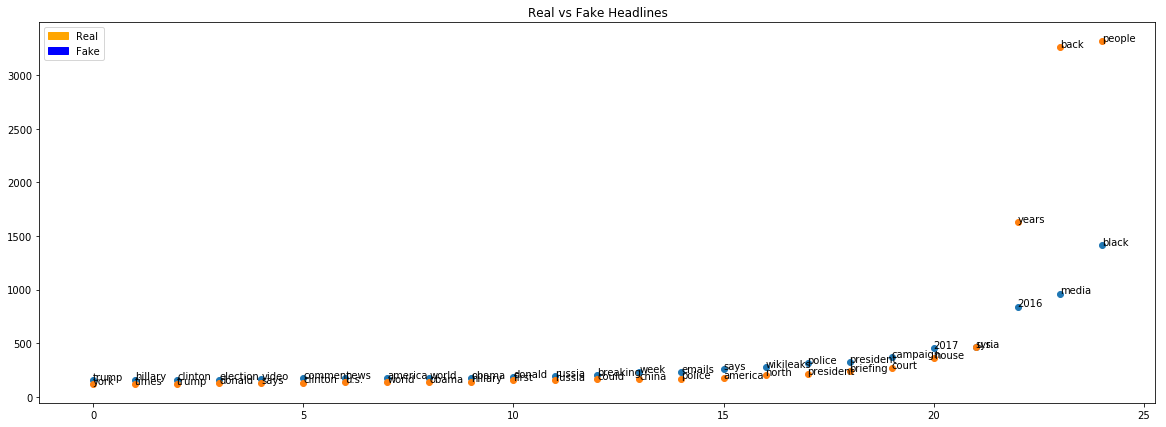

In [6]:
nltk.download('punkt')

df_fakewords = ' '.join(df_fake[df_fake['Label'] == 0]['Headline'])
df_realwords = ' '.join(df_fake[df_fake['Label'] == 1]['Headline'])

fakewords = [word for word in nltk.tokenize.word_tokenize(df_fakewords) if word not in stopwords.words('english') and len(word) > 3]
realwords = [word for word in nltk.tokenize.word_tokenize(df_realwords) if word not in stopwords.words('english') and len(word) > 3]

common_fake = nltk.FreqDist(fakewords).most_common(25)
common_real = nltk.FreqDist(realwords).most_common(25)
fake_ranks = []
fake_counts = []
real_ranks = []
real_counts = []

for ii, word in enumerate(reversed(common_fake)):
    fake_ranks.append(ii)
    fake_counts.append(word[1])

for ii, word in enumerate(reversed(common_real)):
    real_ranks.append(ii)
    real_counts.append(word[1])

plt.figure(figsize=(20, 7))

plt.scatter(fake_ranks, fake_counts)

for labels, fake_rank, fake_count in zip(common_fake, fake_ranks, fake_counts):
    plt.annotate(
        labels[0],
        xy = (fake_rank, fake_count)
    )

plt.scatter(real_ranks, real_counts)
plt.title('Real vs Fake Headlines')

for labels, real_rank, real_count in zip(common_real, real_ranks, real_counts):
    plt.annotate(
        labels[0],
        xy = (real_rank, real_count)
    )

real_patch = mpatches.Patch(color='orange', label='Real')
fake_patch = mpatches.Patch(color='blue', label='Fake')
plt.legend(handles=[real_patch, fake_patch])

plt.show()

In [7]:
fake_word = pd.DataFrame(common_fake)
fake_word = fake_word.drop(1,axis=1)
fake_word['word'] = fake_word[0]
fake_word

,0,word
0,trump,trump
1,hillary,hillary
2,clinton,clinton
3,election,election
4,video,video
5,comment,comment
6,news,news
7,america,america
8,world,world
9,obama,obama


In [8]:
for words in fake_word['word']:
    df_fake[words] = df_fake['Headline'].str.contains(words)==True
    df_fake[words] = df_fake[words].astype(int)

In [9]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21177 entries, 0 to 21176
Data columns (total 33 columns):
index            21177 non-null object
Body             21177 non-null object
Headline         21177 non-null object
Label            21177 non-null int64
Site             21177 non-null object
head_length      21177 non-null int64
body_length      21177 non-null int64
HeadbodyRatio    21177 non-null float64
trump            21177 non-null int32
hillary          21177 non-null int32
clinton          21177 non-null int32
election         21177 non-null int32
video            21177 non-null int32
comment          21177 non-null int32
news             21177 non-null int32
america          21177 non-null int32
world            21177 non-null int32
obama            21177 non-null int32
donald           21177 non-null int32
russia           21177 non-null int32
breaking         21177 non-null int32
week             21177 non-null int32
emails           21177 non-null int32
says       

### 1.1.7 Checking where Grammer !, ?, &, !!!  is used in Headlines as a sign for FakeNews

In [44]:
df_fake['excla'] = df_fake['Headline'].str.contains('!')==True
df_fake['quest'] = df_fake['Headline'].str.contains('\?')==True
df_fake['and1'] = df_fake['Headline'].str.contains('&')==True
df_fake['exclathree'] = df_fake['Headline'].str.contains('!!!')==True

In [45]:
df_fake['excla'] = df_fake.excla.astype(int)
df_fake['quest'] = df_fake.quest.astype(int)
df_fake['and1'] = df_fake.and1.astype(int)
df_fake['exclathree'] = df_fake.exclathree.astype(int)

In [49]:
pd.crosstab(df_fake['quest'], df_fake['Label'])

Label,0,1
quest,,
0,9793,10046
1,830,508


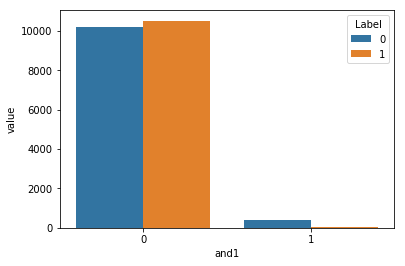

In [35]:
ct = pd.crosstab(df_fake['and1'], df_fake['Label'])
stacked = ct.stack().reset_index().rename(columns={0:'value'})

 # plot grouped bar chart
sns.barplot(x=stacked.and1, y=stacked.value, hue=stacked.Label)

In [25]:
df_fakeplot = df_fake[["excla","quest","and1","Label"]]

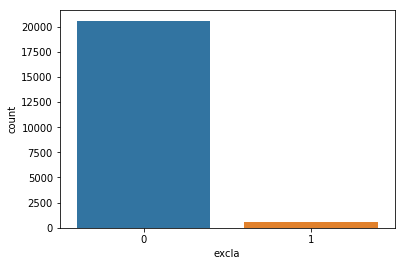

In [31]:
sns.countplot(x='excla', data=df_fakeplot)

In [17]:
df_fake[["Body","Headline"]]

,Body,Headline
0,image copyright getty images\non sunday mornin...,four ways bob corker skewered donald trump
1,"london (reuters) - “last flag flying”, a comed...",linklater's war veteran comedy speaks to moder...
2,the feud broke into public view last week when...,trump’s fight with corker jeopardizes his legi...
3,mexico city (reuters) - egypt’s cheiron holdin...,egypt's cheiron wins tie-up with pemex for mex...
4,"country singer jason aldean, who was performin...",jason aldean opens 'snl' with vegas tribute
5,jetnation fanduel league; week 4\n% of readers...,jetnation fanduel league; week 4
6,"in 2012, kansas lawmakers, led by gov. sam bro...",kansas tried a tax plan similar to trump’s. it...
7,the reserve bank of india (rbi) governor urjit...,"india rbi chief: growth important, but not at ..."
8,"scott pruitt, administrator of the u.s. enviro...",epa chief to sign rule on clean power plan exi...
9,file photo - an air berlin sign is seen at an ...,talks on sale of air berlin planes to easyjet ...


### 1.1.8 Handling non-normal distribution

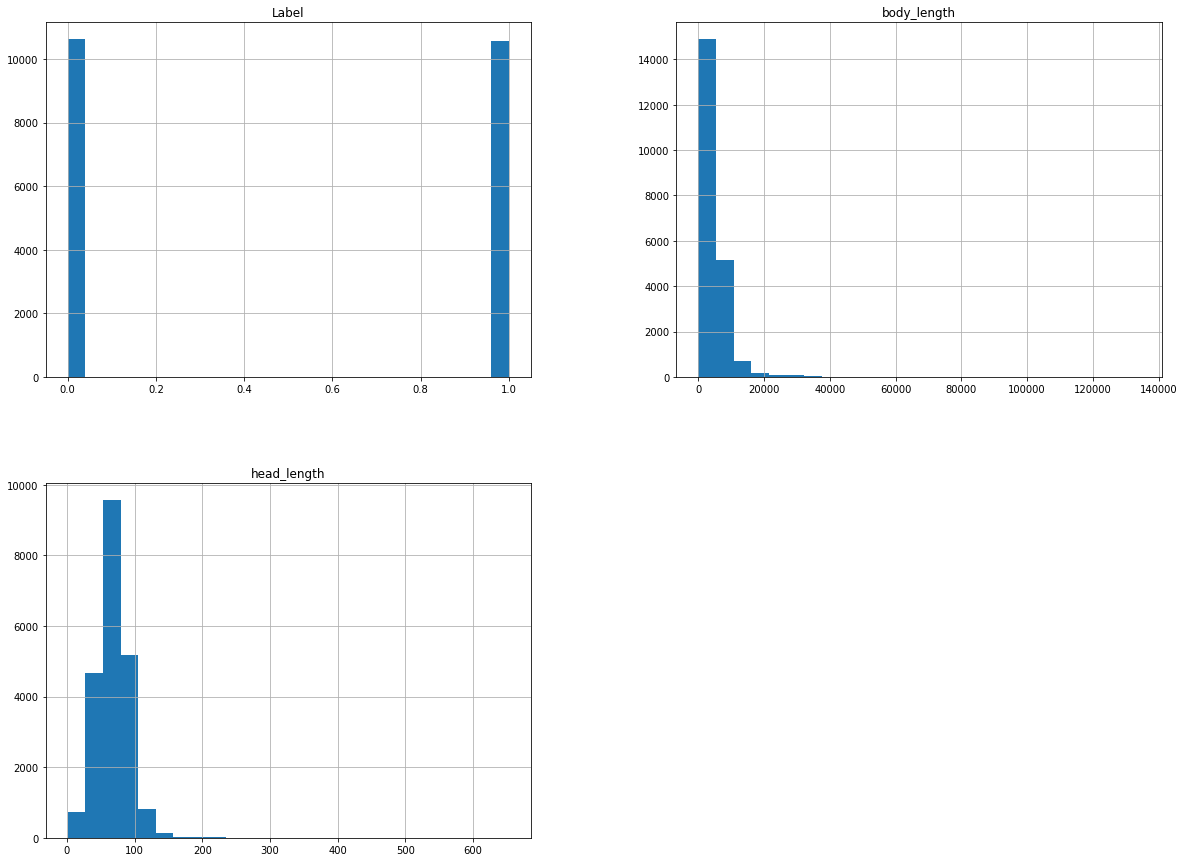

In [51]:
df_fake.hist(bins = 25, figsize = (20,15), column=["body_length","head_length","Label"]) 
plt.show()

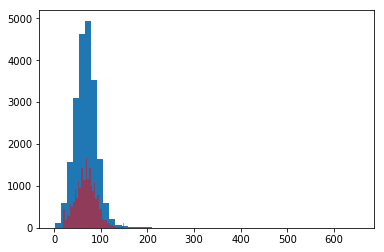

In [52]:
head = np.clip(df_fake['head_length'], 20, 150 )
plt.hist(df_fake['head_length'], bins=50)
plt.hist(head, bins=38, color='red', alpha = 0.5)
plt.show()

In [53]:
df_fake['head_length'] = np.clip(df_fake['head_length'], 20, 150)
df_fake['body_length'] = np.clip(df_fake['body_length'], 50, 7500)

### 1.1.9 WordCloud Picture

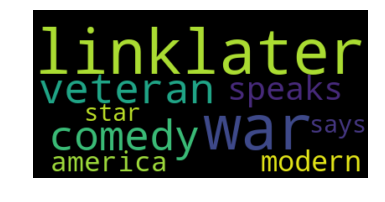

In [68]:
text = df_fake.Headline[1]

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
text = " ".join(Headline for Headline in df_fake.Headline)
print ("There are {} words in the combination of all Headlines.".format(len(text)))


There are 1470371 words in the combination of all Headlines.


In [62]:
text = " ".join(Body for Body in df_fake.Body)
print ("There are {} words in the combination of all Texts.".format(len(text)))

There are 92738400 words in the combination of all Texts.


In [99]:
stopwords = set(STOPWORDS)
stopwords.update(["trump", "vegas","las", "football","new york","hillary","clinton"])

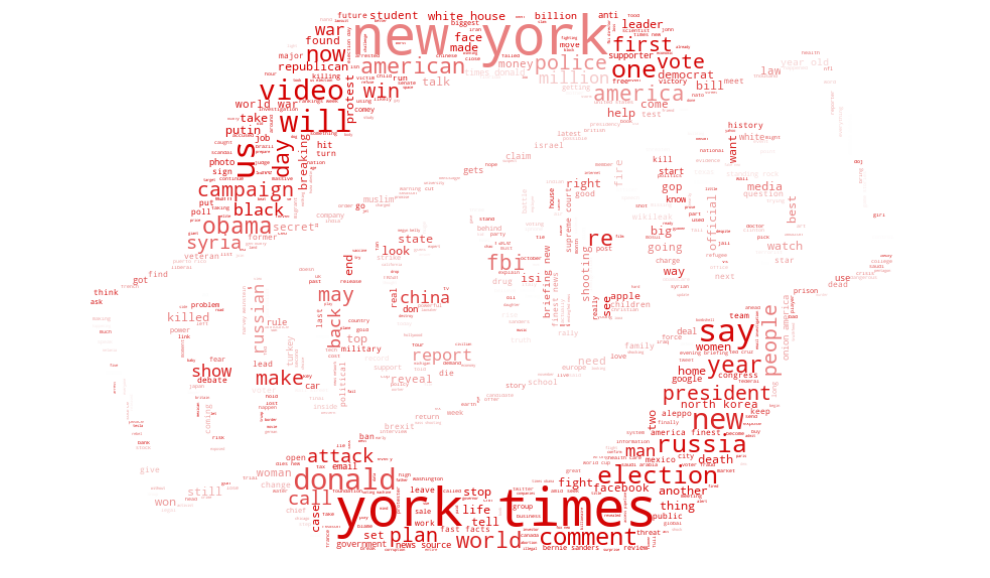

In [102]:
fake_mask = np.array(Image.open("fakepic.png"))
image_colors = ImageColorGenerator(fake_mask)
wordcloud = WordCloud(stopwords=stopwords, mask= fake_mask, background_color="white", mode="RGBA", max_words=1000).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.savefig("img/fakepic.png", format="png")

plt.show()

# 2. Data Preprocessing

Setting DB so we can explore Sentiment Analysis

In [116]:
df_faketrain = df_fake[1:1500]
df_faketrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 1 to 1499
Data columns (total 37 columns):
index            1499 non-null object
Body             1499 non-null object
Headline         1499 non-null object
Label            1499 non-null int64
Site             1499 non-null object
head_length      1499 non-null int64
body_length      1499 non-null int64
HeadbodyRatio    1499 non-null float64
trump            1499 non-null int32
hillary          1499 non-null int32
clinton          1499 non-null int32
election         1499 non-null int32
video            1499 non-null int32
comment          1499 non-null int32
news             1499 non-null int32
america          1499 non-null int32
world            1499 non-null int32
obama            1499 non-null int32
donald           1499 non-null int32
russia           1499 non-null int32
breaking         1499 non-null int32
week             1499 non-null int32
emails           1499 non-null int32
says             1499 non-null int32

Setting Full DB for modeling

In [14]:
# Dropping Site, Body, Headline, URLs columns from our Training Database
df_fortrain = df_fake.drop(columns=["Headline","Body","Site","index"])
df_fortrain
train_df, test_df= train_test_split (df_fortrain, test_size = 0.2, random_state=7)

In [161]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 20763 to 17827
Data columns (total 37 columns):
index            4236 non-null object
Body             4236 non-null object
Headline         4236 non-null object
Label            4236 non-null int64
Site             4236 non-null object
head_length      4236 non-null int64
body_length      4236 non-null int64
HeadbodyRatio    4236 non-null float64
trump            4236 non-null int32
hillary          4236 non-null int32
clinton          4236 non-null int32
election         4236 non-null int32
video            4236 non-null int32
comment          4236 non-null int32
news             4236 non-null int32
america          4236 non-null int32
world            4236 non-null int32
obama            4236 non-null int32
donald           4236 non-null int32
russia           4236 non-null int32
breaking         4236 non-null int32
week             4236 non-null int32
emails           4236 non-null int32
says             4236 non-null 

In [119]:
y = train_df["Label"]
X = train_df

In [15]:
faketrain_df, faketest_df = train_test_split (df_fake, test_size = 0.1, random_state=7)

In [16]:
df_faketrain = faketest_df.reset_index()

In [17]:
faketest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2118 entries, 20763 to 19057
Data columns (total 37 columns):
index            2118 non-null object
Body             2118 non-null object
Headline         2118 non-null object
Label            2118 non-null int64
Site             2118 non-null object
head_length      2118 non-null int64
body_length      2118 non-null int64
HeadbodyRatio    2118 non-null float64
trump            2118 non-null int32
hillary          2118 non-null int32
clinton          2118 non-null int32
election         2118 non-null int32
video            2118 non-null int32
comment          2118 non-null int32
news             2118 non-null int32
america          2118 non-null int32
world            2118 non-null int32
obama            2118 non-null int32
donald           2118 non-null int32
russia           2118 non-null int32
breaking         2118 non-null int32
week             2118 non-null int32
emails           2118 non-null int32
says             2118 non-null 

## 2.1 Running Google's Sentiment Analysis

In [4]:
def gc_sentiment(text):  
    from google.cloud import language
    
    path = '/Users/shtay/fakenews.json' #FULL path to your service account key
    client = language.LanguageServiceClient.from_service_account_json(path)
    document = language.types.Document(
            content=text,
            type=language.enums.Document.Type.PLAIN_TEXT)
    annotations = client.analyze_sentiment(document=document)
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude
    return score, magnitude

In [19]:
from google.cloud import language

from tqdm import tqdm 
gc_results = [gc_sentiment(row) for row in tqdm(df_faketrain["Headline"], ncols = 100)]
gc_score, gc_magnitude = zip(*gc_results) 
gc = list(zip(df_faketrain["Headline"], gc_score, gc_magnitude))
columns = ['text', 'headscore', 'magnitude']
gc_df = pd.DataFrame(gc, columns = columns)

100%|███████████████████████████████████████████████████████████| 2118/2118 [45:33<00:00,  1.58s/it]


In [166]:
df_faketrain.drop(df_faketrain.index[3045:3048])

,index,Body,Headline,Label,Site,head_length,body_length,HeadbodyRatio,trump,hillary,...,campaign,2017,u.s.,2016,media,black,excla,quest,and1,exclathree
20763,8203,’’ ’they came from the restaurant industry in ...,they helped elect president obama and now they...,1,www.businessinsider.com,107,477,4.457944,0,0,...,0,0,0,0,0,0,0,0,0,0
3860,3880,terence mckenna’s true hallucinations\n(before...,terence mckenna’s true hallucinations,0,beforeitsnews.com,37,433,11.702703,0,0,...,0,0,0,0,0,0,0,0,0,0
5622,2997,"november 1, 2016 iranians arrested after celeb...",iranians arrested after celebrating ancient pe...,0,endtime.com,72,509,7.069444,0,0,...,0,0,0,0,0,0,0,0,0,0
17737,5177,"the economic recovery may be durable, but it i...","disappointing 2nd-quarter growth, despite stro...",1,www.nytimes.com,87,6732,77.379310,0,0,...,0,0,0,0,0,0,0,0,0,0
20747,8187,’’ ’’ ’’ ’’ ’’ ’’ ’’ ’’ ’’ ’’ ’’ ’customers us...,chipotle’s $70 million free burrito strategy m...,1,www.businessinsider.com,96,79,0.822917,0,0,...,0,0,0,0,0,0,0,0,0,0
4474,815,several clashes reported around country by jas...,at least 37 killed in yemen fighting since cea...,0,antiwar.com,58,1247,21.500000,0,0,...,0,0,0,0,0,0,0,0,0,0
1159,1169,red flag warning: these california wildfires a...,sheriff won’t charge the teens who talked abou...,0,beforeitsnews.com,66,140,2.121212,0,0,...,0,0,0,0,0,0,0,0,0,0
10164,9388,"\nas of october 29, there have been at least 1...",militarized police brutalize and arrest peacef...,0,thedailysheeple.com,93,2299,24.720430,0,0,...,0,0,0,0,0,0,0,0,0,0
3893,3913,red flag warning: these california wildfires a...,nibiru final warning - ‘just how long does ear...,0,beforeitsnews.com,80,140,1.750000,0,0,...,0,0,0,0,0,0,0,0,0,0
20177,7617,’’ ”jack dorsey’s been working crazy hours sin...,jack dorsey’s 18-hour workdays are about to be...,1,www.businessinsider.com,62,1191,19.209677,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_faketrain["Headscore"] = gc_df["headscore"]
df_faketrain["Headmagnitude"] = gc_df["magnitude"]

In [23]:
pickle.dump(df_faketrain, open("df_faketraingcdf.dat", "wb"))

In [2]:
df_faketrain = pickle.load(open("df_faketraingcdf.dat", "rb"))

In [33]:
from google.cloud import language

from tqdm import tqdm 
gc_results = [gc_sentiment(row) for row in tqdm(df_faketrain["Body"], ncols = 100)]
gc_score, gc_magnitude = zip(*gc_results) 
gc = list(zip(df_faketrain["Body"], gc_score, gc_magnitude))
columns = ['text', 'bodyscore', 'bodymagnitude']
gc_df1 = pd.DataFrame(gc, columns = columns)

















  0%|                                                                      | 0/2105 [00:00<?, ?it/s]















  0%|                                                           | 1/2105 [00:49<29:08:25, 49.86s/it]















  0%|                                                           | 2/2105 [00:51<20:42:15, 35.44s/it]















  0%|                                                           | 3/2105 [00:53<14:50:12, 25.41s/it]















  0%|                                                           | 4/2105 [00:56<10:50:40, 18.58s/it]















  0%|▏                                                           | 5/2105 [00:57<7:52:55, 13.51s/it]















  0%|▏                                                           | 6/2105 [00:59<5:49:36,  9.99s/it]















  0%|▏                                                           | 7/2105 [01:02<4:29:47,  7.72s/it]















  0%|▏                                                  

  7%|███▊                                                      | 140/2105 [06:48<1:01:01,  1.86s/it]















  7%|███▉                                                      | 141/2105 [06:50<1:01:34,  1.88s/it]















  7%|████                                                        | 142/2105 [06:51<58:46,  1.80s/it]















  7%|████                                                        | 143/2105 [06:53<59:55,  1.83s/it]















  7%|███▉                                                      | 144/2105 [06:56<1:07:03,  2.05s/it]















  7%|███▉                                                      | 145/2105 [06:58<1:08:52,  2.11s/it]















  7%|████                                                      | 146/2105 [07:01<1:14:25,  2.28s/it]















  7%|████                                                      | 147/2105 [07:03<1:13:15,  2.24s/it]















  7%|████                                                      | 148/210

InternalServerError: 500 Exception deserializing response!

In [30]:
df_faketrain =  df_faketrain.drop(df_faketrain.index[[219]])


In [27]:
df_faketrain.iloc[8]

level_0                                                      20177
index                                                         7617
Body             ’’ ”jack dorsey’s been working crazy hours sin...
Headline         jack dorsey’s 18-hour workdays are about to be...
Label                                                            1
Site                                       www.businessinsider.com
head_length                                                     62
body_length                                                   1191
HeadbodyRatio                                            0.0520571
trump                                                            0
hillary                                                          0
clinton                                                          0
election                                                         0
video                                                            0
comment                                                       

In [204]:
df_faketrain2 = df_faketrain

In [211]:
df_faketrain =  df_faketrain.drop(df_faketrain.index[[1018]])

In [318]:
gc_df1.iloc[1020]

text         shahzaib elahi\ncontributor profile | more sto...
bodyscore                                                    0
magnitude                                                  1.4
Name: 1020, dtype: object

In [127]:

df_faketrain["Bodyscore"] = gc_df1["bodyscore"]
df_faketrain["Bodymagnitude"] = gc_df1["magnitude"]

C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [128]:
df_faketrain['sentimenthead'] = df_faketrain['Headscore'] * df_faketrain['Headmagnitude']
df_faketrain['sentimentbody'] = df_faketrain['Bodyscore'] * df_faketrain['Bodymagnitude']
df_faketrain['sentimenttotal'] = df_faketrain['sentimenthead'] * df_faketrain['sentimentbody']

C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\shtay\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [129]:
df_faketrain = df_faketrain.dropna()
df_faketrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 1 to 1498
Data columns (total 44 columns):
index             1498 non-null object
Body              1498 non-null object
Headline          1498 non-null object
Label             1498 non-null int64
Site              1498 non-null object
head_length       1498 non-null int64
body_length       1498 non-null int64
HeadbodyRatio     1498 non-null float64
trump             1498 non-null int32
hillary           1498 non-null int32
clinton           1498 non-null int32
election          1498 non-null int32
video             1498 non-null int32
comment           1498 non-null int32
news              1498 non-null int32
america           1498 non-null int32
world             1498 non-null int32
obama             1498 non-null int32
donald            1498 non-null int32
russia            1498 non-null int32
breaking          1498 non-null int32
week              1498 non-null int32
emails            1498 non-null int32
says         

In [130]:
pickle.dump(df_faketrain, open("df_faketrain.dat", "wb"))

In [151]:
faketrain_df = pickle.load(open("df_faketrain.dat", "rb"))

In [152]:
faketrain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 1 to 1498
Data columns (total 44 columns):
index             1498 non-null object
Body              1498 non-null object
Headline          1498 non-null object
Label             1498 non-null int64
Site              1498 non-null object
head_length       1498 non-null int64
body_length       1498 non-null int64
HeadbodyRatio     1498 non-null float64
trump             1498 non-null int32
hillary           1498 non-null int32
clinton           1498 non-null int32
election          1498 non-null int32
video             1498 non-null int32
comment           1498 non-null int32
news              1498 non-null int32
america           1498 non-null int32
world             1498 non-null int32
obama             1498 non-null int32
donald            1498 non-null int32
russia            1498 non-null int32
breaking          1498 non-null int32
week              1498 non-null int32
emails            1498 non-null int32
says         

In [60]:
yfake = faketrain_df["Label"]
Xfake = faketrain_df

## 2.2 Exploring Train Data

In [68]:
train_df_numeric = train_df.iloc[:, 0:11] 
corr_df=train_df_numeric.corr()
corr_df

,Label,head_length,body_length,check,trump,hillary,clinton,election,video,comment,news
Label,1.000000,0.001786,0.216372,-0.055949,0.024057,-0.169815,-0.130619,-0.114972,-0.130268,-0.123005,-0.081529
head_length,0.001786,1.000000,0.059304,0.041526,0.061498,0.119114,0.123575,0.046675,0.074674,0.220742,0.109941
body_length,0.216372,0.059304,1.000000,-0.107953,0.024569,-0.030824,0.019109,0.010402,-0.085106,0.052428,-0.055292
check,-0.055949,0.041526,-0.107953,1.000000,0.002422,0.032461,0.006252,0.000973,0.012447,-0.009789,-0.003714
trump,0.024057,0.061498,0.024569,0.002422,1.000000,0.006202,0.027224,0.004146,0.042772,-0.006665,0.020880
hillary,-0.169815,0.119114,-0.030824,0.032461,0.006202,1.000000,0.419152,0.039057,0.036907,0.048716,0.049463
clinton,-0.130619,0.123575,0.019109,0.006252,0.027224,0.419152,1.000000,0.035421,0.015001,0.059494,0.041653
election,-0.114972,0.046675,0.010402,0.000973,0.004146,0.039057,0.035421,1.000000,0.035007,0.007197,0.034406
video,-0.130268,0.074674,-0.085106,0.012447,0.042772,0.036907,0.015001,0.035007,1.000000,0.002035,0.012261
comment,-0.123005,0.220742,0.052428,-0.009789,-0.006665,0.048716,0.059494,0.007197,0.002035,1.000000,-0.005541


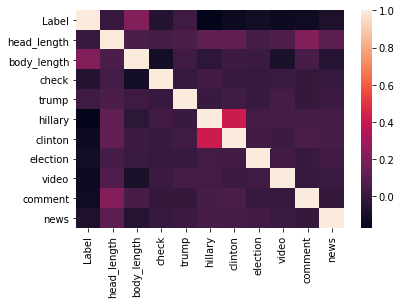

In [69]:
sns.heatmap(corr_df)

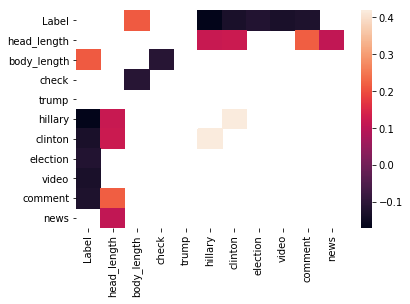

In [70]:
sns.heatmap(corr_df[(corr_df<1) & ((corr_df >= 0.1) | (corr_df <= -0.1)) ] )

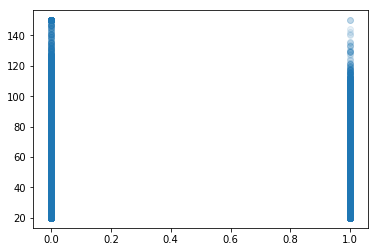

In [71]:
plt.scatter(data = train_df, x="Label", y="head_length", alpha=0.1)

In [43]:
sns.pairplot(train_df_numeric, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.05}})

NameError: name 'train_df_numeric' is not defined

Label
0    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
1    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

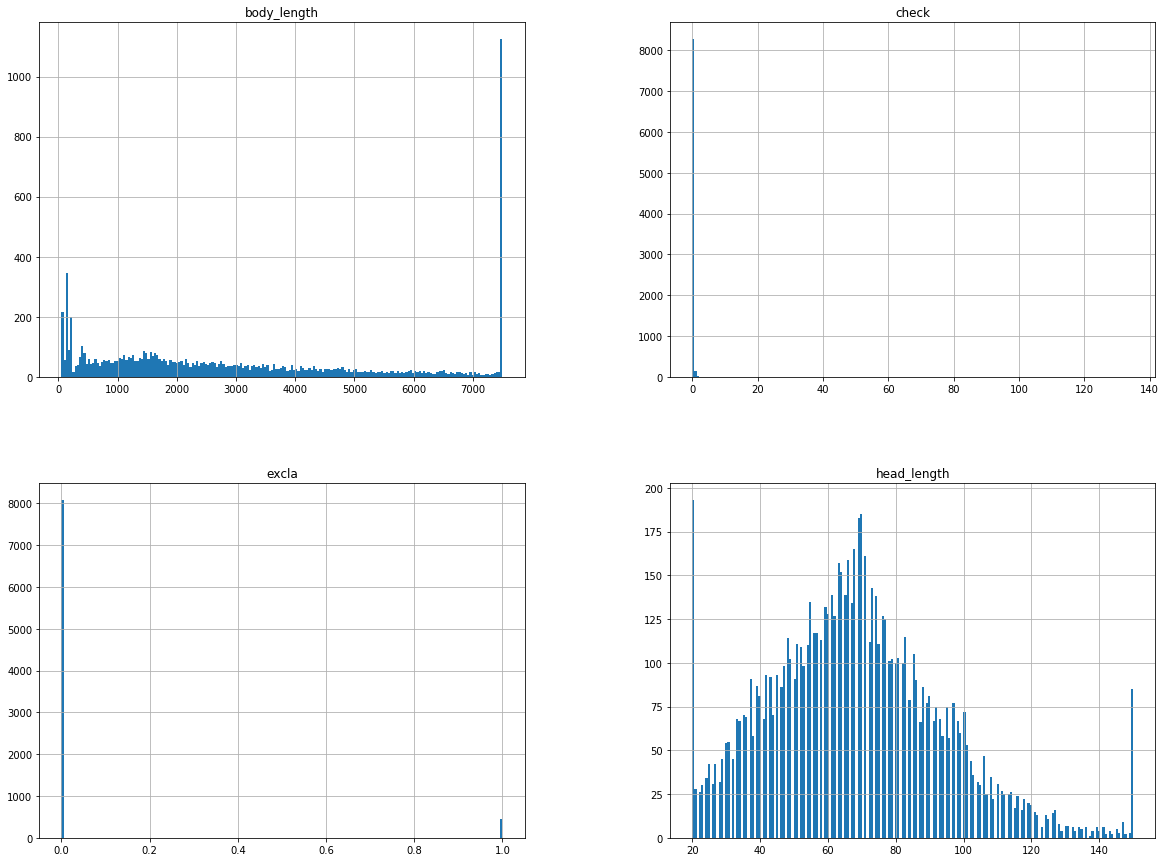

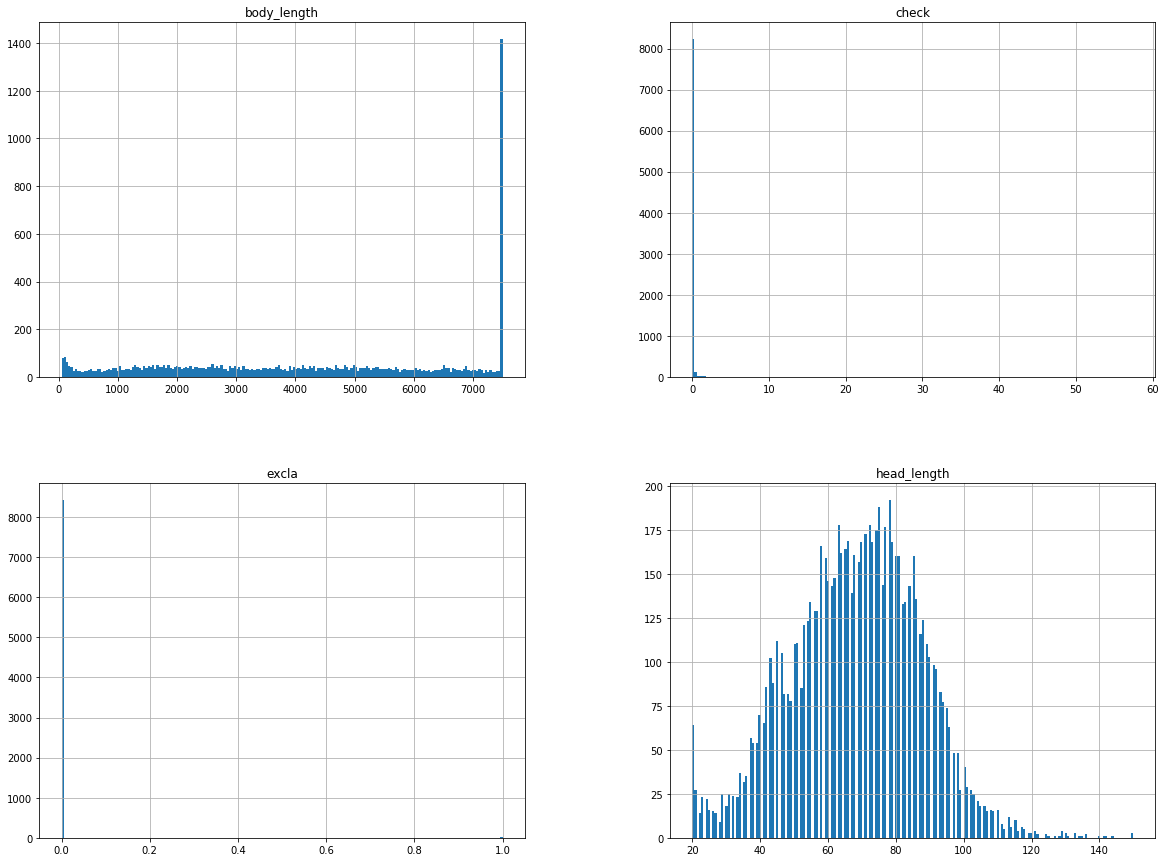

In [73]:
train_df.groupby(['Label']).hist(bins = 200, figsize = (20,15), column=["head_length", "body_length", "excla", "check"])

## 2.3 Plots

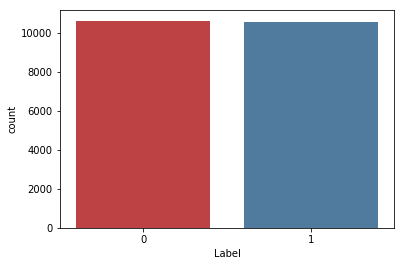

In [104]:
sns.countplot(x='Label', data=df_fake, saturation=0.6,palette="Set1")

In [131]:
df_faketrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 1 to 1498
Data columns (total 44 columns):
index             1498 non-null object
Body              1498 non-null object
Headline          1498 non-null object
Label             1498 non-null int64
Site              1498 non-null object
head_length       1498 non-null int64
body_length       1498 non-null int64
HeadbodyRatio     1498 non-null float64
trump             1498 non-null int32
hillary           1498 non-null int32
clinton           1498 non-null int32
election          1498 non-null int32
video             1498 non-null int32
comment           1498 non-null int32
news              1498 non-null int32
america           1498 non-null int32
world             1498 non-null int32
obama             1498 non-null int32
donald            1498 non-null int32
russia            1498 non-null int32
breaking          1498 non-null int32
week              1498 non-null int32
emails            1498 non-null int32
says         

#### Site Categorizing

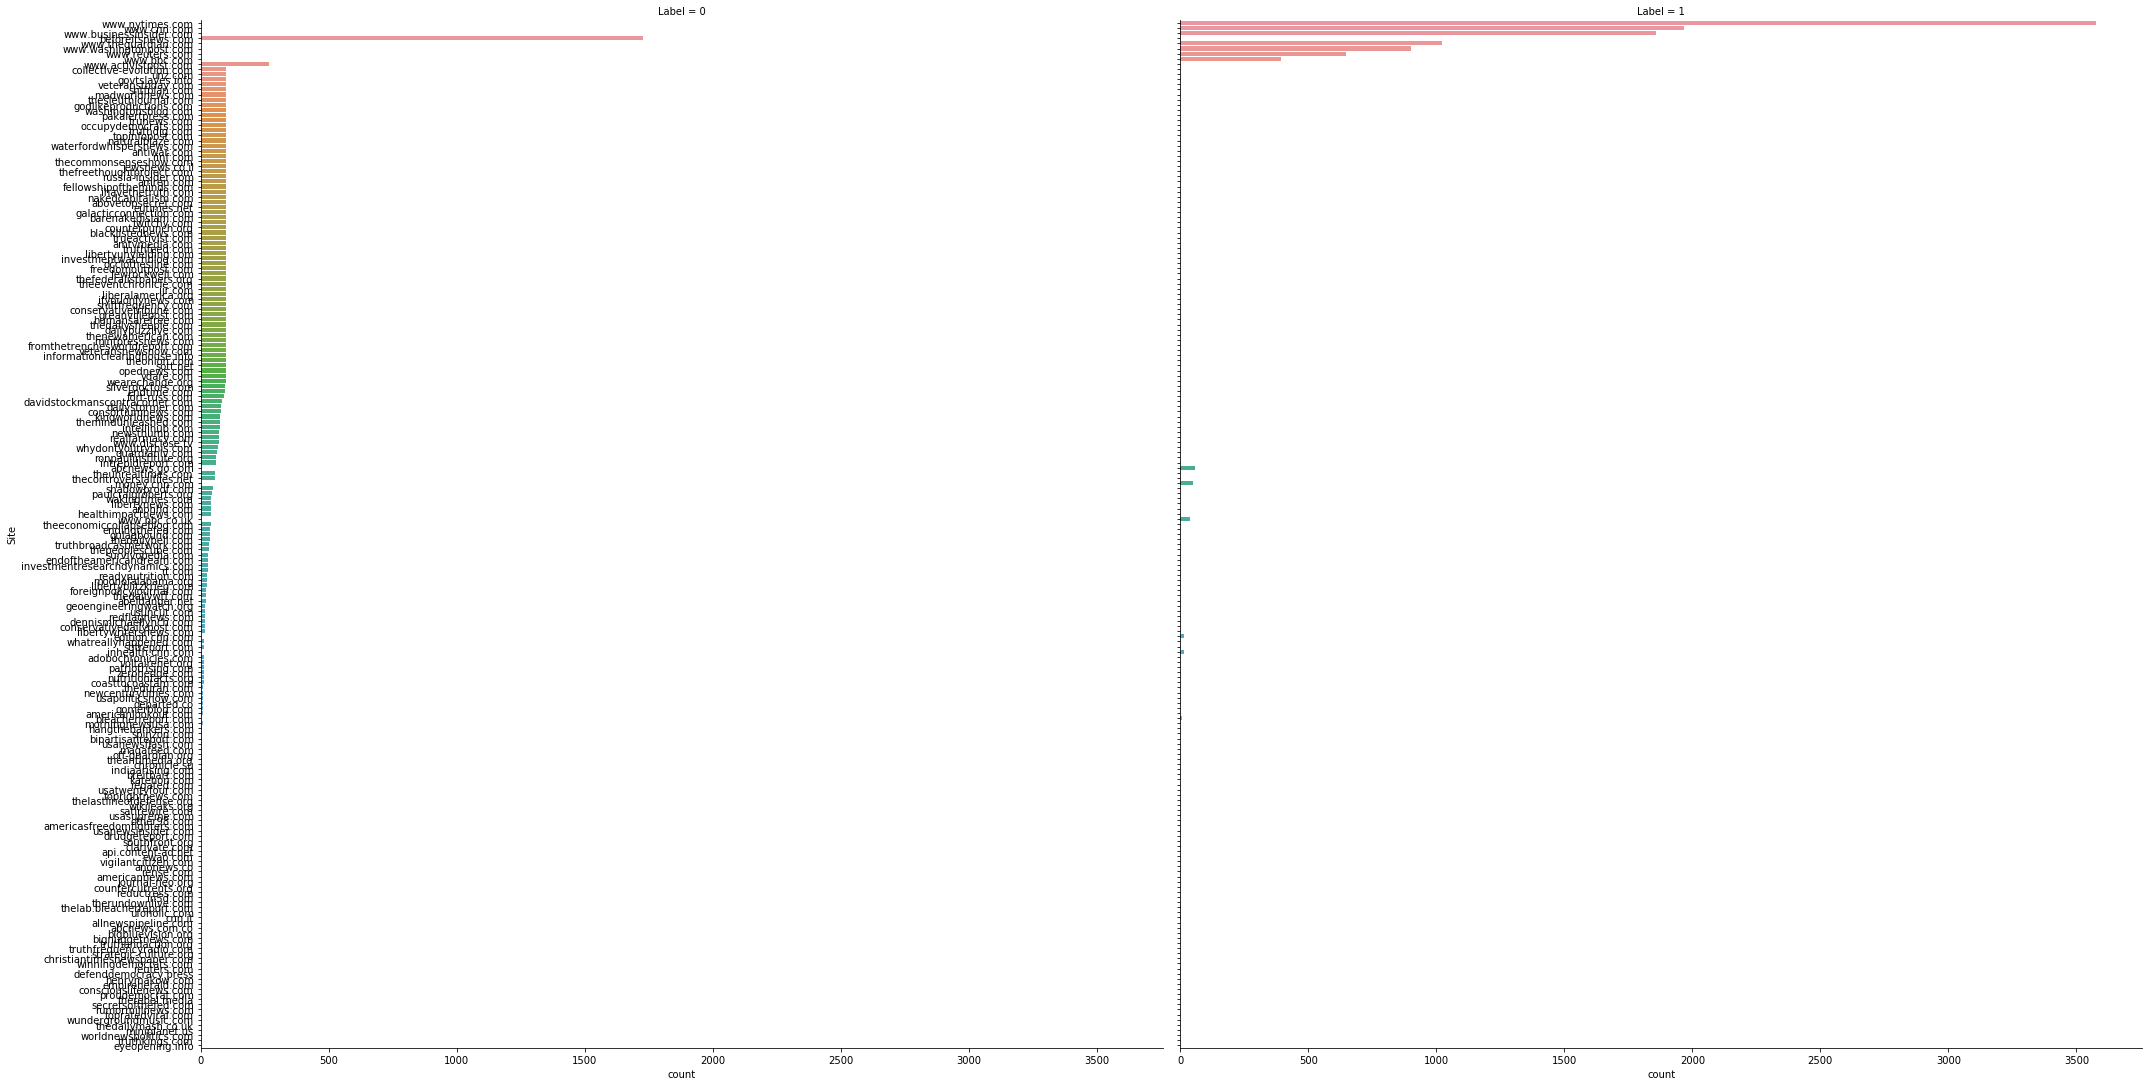

In [105]:
sns.catplot(y="Site", col="Label",data=df_fake,order=df_fake['Site'].value_counts().index , kind="count", height=15)

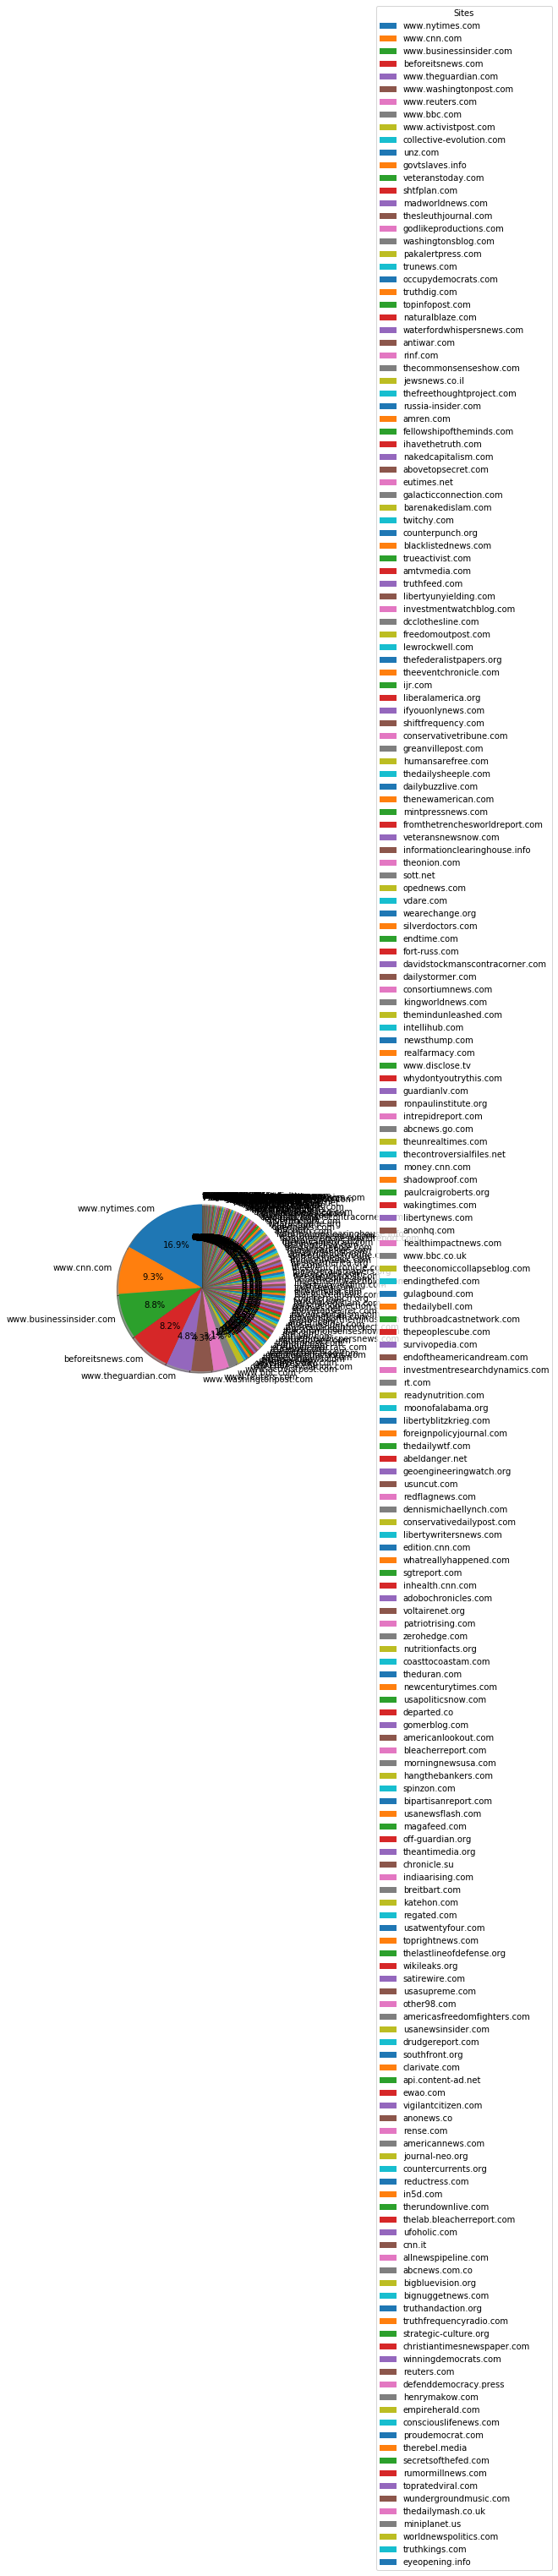

In [106]:
fig1, ax1 = plt.subplots()

slices = df_fake["Site"].value_counts()
labels = slices.index
ax1.pie(slices, autopct='%1.1f%%', labels=labels,shadow=True, startangle=90,)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(loc="center left", title="Sites",bbox_to_anchor=(1.1, 1, 0, -1))
plt.show()

#### Length Plots

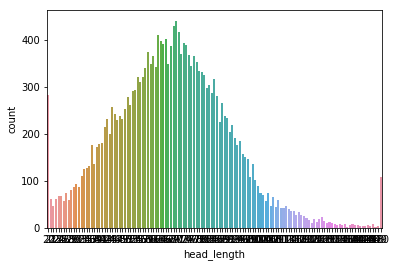

In [108]:
sns.countplot(x='head_length',data=df_fake)

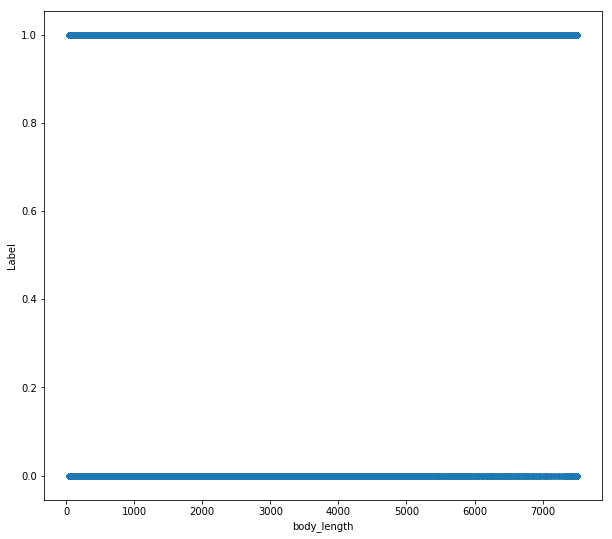

In [109]:
df_fake.plot(x='body_length', y='Label', figsize=(10,9),kind='scatter')

Comparing between Fake & Real articles

In [9]:
dfFake = df_fake[df_fake['Label']==False]
dfTrue = df_fake[df_fake['Label']==True]

In [12]:
dfFake.describe()

,Label,head_length,body_length,HeadbodyRatio,excla,quest,and1,exclathree
count,10623.0,10623.00000,10623.000000,10623.000000,10623.000000,10623.000000,10623.000000,10623.000000
mean,0.0,68.39744,3978.361103,0.710822,0.052810,0.078132,0.039537,0.001789
std,0.0,28.78374,5703.993641,7.111979,0.223664,0.268392,0.194878,0.042256
min,0.0,1.00000,1.000000,0.000096,0.000000,0.000000,0.000000,0.000000
25%,0.0,50.00000,1114.500000,0.012369,0.000000,0.000000,0.000000,0.000000
50%,0.0,67.00000,2517.000000,0.027038,0.000000,0.000000,0.000000,0.000000
75%,0.0,83.00000,4991.500000,0.062641,0.000000,0.000000,0.000000,0.000000
max,0.0,653.00000,134206.000000,156.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
dfFake['HeadbodyRatio'] = dfFake['body_length'] / dfFake['head_length']


In [112]:
dfTrue.describe()

,Label,head_length,body_length,HeadbodyRatio,trump,hillary,clinton,election,video,comment,...,campaign,2017,u.s.,2016,media,black,excla,quest,and1,exclathree
count,10554.0,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,...,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.000000,10554.0
mean,1.0,68.473565,4246.253079,0.106431,0.156718,0.016676,0.026530,0.011939,0.004738,0.002085,...,0.010233,0.006348,0.106026,0.007864,0.007391,0.010517,0.003506,0.048133,0.002937,0.0
std,0.0,18.920725,2386.044404,1.582617,0.363552,0.128061,0.160713,0.108615,0.068670,0.045611,...,0.100645,0.079427,0.307886,0.088336,0.085654,0.102018,0.059109,0.214058,0.054120,0.0
min,1.0,20.000000,50.000000,0.000809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.0,56.000000,2151.000000,0.010448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.0,69.000000,4256.000000,0.015837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.0,82.000000,6535.000000,0.030420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.0,150.000000,7500.000000,80.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [11]:
print("Body Length of Fake Articles: ", round(dfFake['body_length'].mean()), "Body Length of Real Articles:", round(dfTrue['body_length'].mean()))
print("Head Length of Fake Articles: ", round(dfFake['head_length'].mean()), "Head Length of Real Articles:", round(dfTrue['head_length'].mean()))
print("Relation between Head & Body in Fake Articles: ", dfFake['HeadbodyRatio'].mean(), "Relation between Head & Body in Real Articles:", dfTrue['HeadbodyRatio'].mean())

Body Length of Fake Articles:  3978 Body Length of Real Articles: 4781
Head Length of Fake Articles:  68 Head Length of Real Articles: 68
Relation between Head & Body in Fake Articles:  0.7108219368176311 Relation between Head & Body in Real Articles: 0.10643106793684433


C:\Users\shtay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


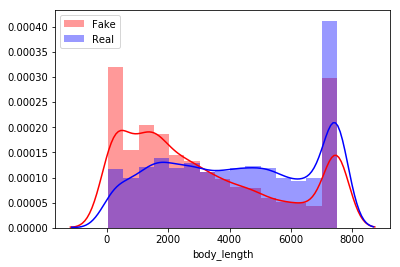

In [114]:
sns.distplot(dfFake['body_length'], bins=15, color="Red",label="Fake")
sns.distplot(dfTrue['body_length'], bins=15, color="Blue",label="Real")
plt.legend()

C:\Users\shtay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


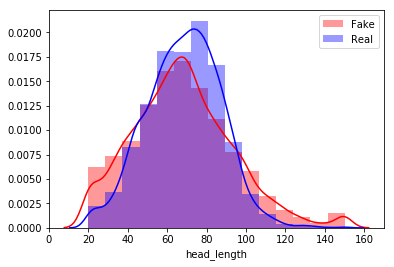

In [115]:
sns.distplot(dfFake['head_length'], bins=15, color="Red",label="Fake")
sns.distplot(dfTrue['head_length'], bins=15, color="Blue",label="Real")
plt.legend()

In [224]:
corrs = df_fakerme.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

C:\Users\shtay\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



In [250]:
df_fakeend = df_fakerme[['Label','excla', 'and1', 'Headscore','Headmagnitude','Bodyscore','Bodymagnitude','sentimenthead','sentimentbody','sentimenttotal','head_length','body_length','HeadbodyRatio']]
df_fakeend["Label"] = df_fakeend["Label"].astype(int)

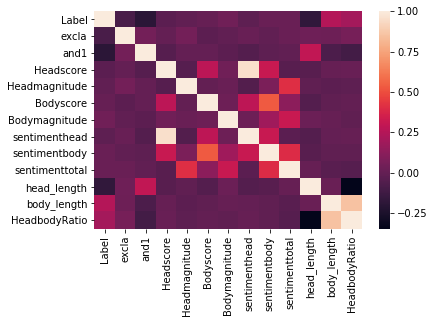

In [251]:
corr_df=df_fakeend.corr()
corr_df
sns.heatmap(corr_df)

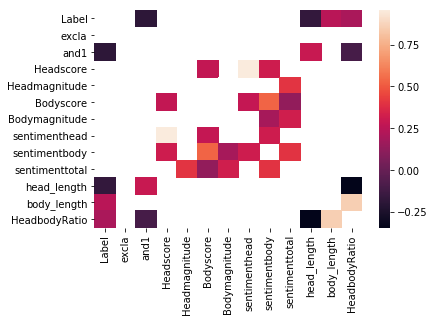

In [298]:
sns.heatmap(corr_df[(corr_df<1) & ((corr_df >= 0.1) | (corr_df <= -0.1)) ] )

In [283]:
df_faken = df_fakeend[['HeadbodyRatio','sentimenttotal','Label']]

C:\Users\shtay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



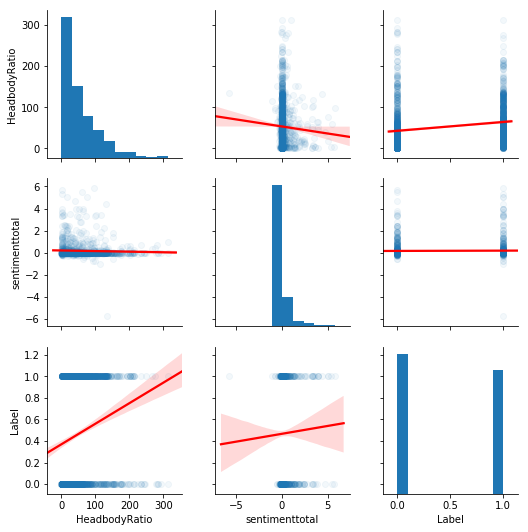

In [286]:
sns.pairplot(df_faken, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.05}})

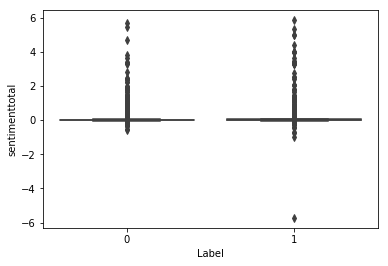

In [293]:
sns.boxplot(x='Label', y='sentimenttotal', data=df_fakeend)

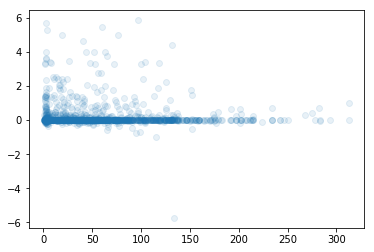

In [295]:
plt.scatter(data = df_fakeend, x="HeadbodyRatio", y="sentimenttotal", alpha=0.1)

In [276]:
df_faken["Label"] = df_faken["Label"].astype(int)

In [265]:
df_fakeend.iplot(x='head_length', y='body_length', z='HeadbodyRatio', kind='bubble3d', xTitle='sentiment', yTitle='ratio',
         zTitle='body length', theme='pearl', size='sentimenttotal',
         categories='Label', title='3D Bubble Plot Sized by Read Ratio and Colored by Type')

In [434]:
df_fakeend.set_index('sentimenttotal')[['body_length', 'HeadbodyRatio']].iplot(
    kind='spread', mode='markers', yTitle='sentiment', title='Spread between Views and Reads')

Clustering

Text(0,0.5,'Internal Sum of Squares')

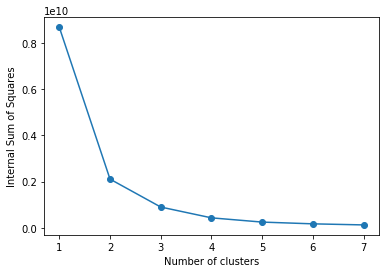

In [267]:
iner_score = []
for i in range (1, 8):   # Go over possible number of clusters i
    km = KMeans (n_clusters=i)
    km.fit(df_fakeend)
    iner_score.append(km.inertia_)
plt.plot(range (1, 8), iner_score, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Internal Sum of Squares")

### 2.4 Data Scaling 

In [62]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

In [75]:
train_df_std = stdsc.fit_transform(train_df)
test_df_std = stdsc.transform(test_df)

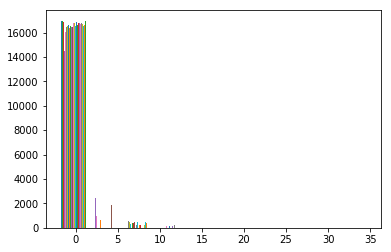

In [76]:
plt.hist(train_df_std)
plt.show()

trump std

In [60]:
train_df_std_tr = stdsc.fit_transform(train_df_tr)
test_df_std_tr = stdsc.transform(test_df_tr)

With Sentiment STD

In [63]:
train_df_std_fake = stdsc.fit_transform(faketrain_df)
test_df_std_fake = stdsc.transform(faketest_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [56]:
# Dropping Site, Body, Headline, URLs columns from our Training Database
df_faketrain = df_faketrain.drop(columns=["Headline","Body","Site","index"])
df_faketrain
faketrain_df, faketest_df= train_test_split (df_faketrain, test_size = 0.25, random_state=7)

KeyError: "['Headline' 'Body' 'Site' 'index'] not found in axis"

In [59]:
faketrain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 857 to 176
Data columns (total 11 columns):
Label             1124 non-null int64
head_length       1124 non-null int64
body_length       1124 non-null int64
check             1124 non-null float64
Headscore         1124 non-null float64
Headmagnitude     1124 non-null float64
Bodyscore         1124 non-null float64
Bodymagnitude     1124 non-null float64
sentimenthead     1124 non-null float64
sentimentbody     1124 non-null float64
sentimenttotal    1124 non-null float64
dtypes: float64(8), int64(3)
memory usage: 105.4 KB


### 2.5 Wrapping up - Pickle

In [78]:
pickle.dump(train_df, open("train_df.dat", "wb"))

In [79]:
train_df_read = pickle.load(open("train_df.dat", "rb"))
train_df_read.describe()

,Label,head_length,body_length,check,trump,hillary,clinton,election,video,comment,...,campaign,2017,u.s.,2016,media,black,excla,quest,and1,exclathree
count,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,...,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000,16967.000000
mean,0.498085,68.124300,3697.320269,0.381704,0.144162,0.054223,0.054812,0.031355,0.025638,0.018978,...,0.013084,0.010314,0.109094,0.013791,0.011905,0.014793,0.027583,0.064183,0.021159,0.000825
std,0.500011,22.736658,2500.279409,4.928325,0.351264,0.226464,0.227620,0.174280,0.158057,0.136451,...,0.113639,0.101036,0.311766,0.116628,0.108464,0.120729,0.163779,0.245087,0.143918,0.028714
min,0.000000,20.000000,50.000000,0.000096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,1506.000000,0.010995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,68.000000,3346.000000,0.019850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,82.000000,5973.000000,0.044833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,150.000000,7500.000000,135.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
pickle.dump(test_df, open("test_df.dat", "wb"))
pickle.dump(train_df_std, open("train_df_std.dat", "wb"))
pickle.dump(test_df_std, open("test_df_std.dat", "wb"))

NameError: name 'test_df' is not defined

trump pickle

In [55]:
pickle.dump(train_df_tr, open("train_df_tr.dat", "wb"))

In [56]:
train_df_read_tr = pickle.load(open("train_df_tr.dat", "rb"))
train_df_read_tr.describe()

,Label,head_length,body_length,check,trump,hillary,clinton,election,video,comment,...,campaign,2017,u.s.,2016,media,black,excla,quest,and1,exclathree
count,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,...,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000,16883.000000
mean,0.491382,68.641711,4368.437126,0.412395,0.145827,0.055263,0.055914,0.030741,0.024462,0.019546,...,0.013979,0.010425,0.108748,0.012439,0.011491,0.015459,0.028786,0.063674,0.021501,0.000888
std,0.499941,24.573466,4764.989348,5.176502,0.352943,0.228499,0.229763,0.172620,0.154485,0.138439,...,0.117405,0.101571,0.311333,0.110836,0.106581,0.123374,0.167211,0.244178,0.145051,0.029795
min,0.000000,1.000000,1.000000,0.000096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,1521.500000,0.011065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,68.000000,3348.000000,0.019899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,83.000000,5954.500000,0.044606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,653.000000,134206.000000,135.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
pickle.dump(test_df_tr, open("test_df_tr.dat", "wb"))
pickle.dump(train_df_std_tr, open("train_df_std_tr.dat", "wb"))
pickle.dump(test_df_std_tr, open("test_df_std_tr.dat", "wb"))

With Sentiment Pickle

In [66]:
pickle.dump(faketrain_df, open("faketrain_df.dat", "wb"))
pickle.dump(faketest_df, open("faketest_df.dat", "wb"))

In [3]:
faketrain_df = pickle.load(open("faketrain_df.dat", "rb"))
faketrain_df.describe()

,Label,head_length,body_length,check,Headscore,Headmagnitude,Bodyscore,Bodymagnitude,sentimenthead,sentimentbody,sentimenttotal
count,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000,1124.000000
mean,0.470641,59.741103,3036.130783,0.112210,0.028292,0.323577,-0.018416,8.568061,0.004671,-0.081664,0.022616
std,0.499359,19.791650,2989.643783,0.189031,0.396602,0.269139,0.222446,9.922375,0.263048,2.288945,0.102079
min,0.000000,6.000000,66.000000,0.002019,-0.900000,0.000000,-0.900000,0.000000,-0.810000,-8.950000,-0.560000
25%,0.000000,47.750000,581.250000,0.012701,-0.200000,0.100000,-0.100000,0.900000,-0.040000,-0.365000,0.000000
50%,0.000000,60.000000,2284.000000,0.025103,0.000000,0.300000,0.000000,5.800000,0.000000,0.000000,0.000000
75%,1.000000,69.000000,4584.500000,0.094929,0.300000,0.500000,0.100000,12.600000,0.090000,0.020000,0.040000
max,1.000000,178.000000,22813.000000,1.393939,0.900000,1.400000,0.900000,124.199997,0.810000,24.840000,0.810000


In [4]:
faketest_df = pickle.load(open("faketest_df.dat", "rb"))

# 3. Reading Our Data

In [5]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import pickle

In [14]:
faketrain_df = pickle.load(open("faketrain_df.dat", "rb")) 
faketest_df = pickle.load(open("faketest_df.dat", "rb"))

In [321]:
faketrain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 857 to 176
Data columns (total 11 columns):
Label             1124 non-null int64
head_length       1124 non-null int64
body_length       1124 non-null int64
check             1124 non-null float64
Headscore         1124 non-null float64
Headmagnitude     1124 non-null float64
Bodyscore         1124 non-null float64
Bodymagnitude     1124 non-null float64
sentimenthead     1124 non-null float64
sentimentbody     1124 non-null float64
sentimenttotal    1124 non-null float64
dtypes: float64(8), int64(3)
memory usage: 105.4 KB


In [137]:
train_df = pickle.load(open("train_df.dat", "rb")) 
test_df = pickle.load(open("test_df.dat", "rb"))

In [20]:
faketrain_df = pickle.load(open("faketrain_df.dat", "rb"))
faketest_df = pickle.load(open("faketest_df.dat", "rb"))

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16967 entries, 13827 to 16921
Data columns (total 33 columns):
Label          16967 non-null int64
head_length    16967 non-null int64
body_length    16967 non-null int64
check          16967 non-null float64
trump          16967 non-null int32
hillary        16967 non-null int32
clinton        16967 non-null int32
election       16967 non-null int32
video          16967 non-null int32
comment        16967 non-null int32
news           16967 non-null int32
america        16967 non-null int32
world          16967 non-null int32
obama          16967 non-null int32
donald         16967 non-null int32
russia         16967 non-null int32
breaking       16967 non-null int32
week           16967 non-null int32
emails         16967 non-null int32
says           16967 non-null int32
wikileaks      16967 non-null int32
police         16967 non-null int32
president      16967 non-null int32
campaign       16967 non-null int32
2017           16967 

In [139]:
test_df.describe()

,Label,head_length,body_length,check,trump,hillary,clinton,election,video,comment,...,campaign,2017,u.s.,2016,media,black,excla,quest,and1,exclathree
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,...,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,0.503300,68.264969,3681.943659,0.520017,0.156766,0.056577,0.055870,0.033239,0.020509,0.019802,...,0.014851,0.014380,0.102782,0.009194,0.012023,0.016266,0.030646,0.058463,0.022867,0.001179
std,0.500048,22.329509,2474.447414,6.015994,0.363623,0.231060,0.229697,0.179281,0.141751,0.139336,...,0.120973,0.119065,0.303709,0.095454,0.108999,0.126511,0.172377,0.234645,0.149496,0.034316
min,0.000000,20.000000,50.000000,0.000327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,1535.500000,0.011179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,68.000000,3301.000000,0.020345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,82.000000,5832.750000,0.043409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,150.000000,7500.000000,156.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
y = train_df["Label"]
X = train_df.drop("Label", axis = 1)
X2 = train_df[["head_length","body_length"]]
x_test = test_df.drop("Label", axis = 1)
y_test = test_df["Label"]
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16967 entries, 13827 to 16921
Data columns (total 2 columns):
head_length    16967 non-null int64
body_length    16967 non-null int64
dtypes: int64(2)
memory usage: 397.7 KB


In [141]:
from sklearn.model_selection import train_test_split
labels = train_df.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(train_df ,labels, test_size = 0.25)

Splitting our db with Sentiment

In [6]:
y_trainfake = faketrain_df["Label"]
x_trainfake = faketrain_df.drop("Label", axis = 1)
x_testfake = faketest_df.drop("Label", axis = 1)
y_testfake = faketest_df["Label"]


In [7]:
from sklearn.model_selection import train_test_split
labels = faketrain_df.pop('Label')
x_trainfake, x_testfake, y_trainfake, y_testfake = train_test_split(faketrain_df ,labels, test_size = 0.25)

In [8]:
x_trainfake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 125 to 1139
Data columns (total 10 columns):
head_length       843 non-null int64
body_length       843 non-null int64
check             843 non-null float64
Headscore         843 non-null float64
Headmagnitude     843 non-null float64
Bodyscore         843 non-null float64
Bodymagnitude     843 non-null float64
sentimenthead     843 non-null float64
sentimentbody     843 non-null float64
sentimenttotal    843 non-null float64
dtypes: float64(8), int64(2)
memory usage: 72.4 KB


# 4. Modeling

In [9]:
# Importing everything we need
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import roc_curve
from sklearn.tree import export_graphviz #In the cmd line type: conda install python-graphviz
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn import ensemble

###  4.1 GridSearch

In [12]:
param_n_estimators_range = [10, 20, 40, 50]
param_max_depth_range =  [2, 4, 5, 10,20] 
param_max_feature_range = [1,2,4,6]

param_grid = [{'n_estimators': param_n_estimators_range, 'max_depth':param_max_depth_range, 'max_features':param_max_feature_range},
              {'n_estimators': param_n_estimators_range, 'max_depth':param_max_depth_range,'max_features':param_max_feature_range, 'bootstrap': ['False']}]

In [13]:
gs = GridSearchCV (estimator=RandomForestRegressor(), param_grid = param_grid, cv=10)
gs = gs.fit (X=x_trainfake, y=y_trainfake.ravel())
print ('The best score is:', gs.best_score_, '\nThe best parameters are:', gs.best_params_)

The best score is: 0.2587099326306227 
The best parameters are: {'max_depth': 10, 'max_features': 6, 'n_estimators': 50}


### 4.2 Smal Tree

In [17]:
x_trainfake = x_trainfake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 125 to 1139
Data columns (total 10 columns):
head_length       843 non-null int64
body_length       843 non-null int64
check             843 non-null float64
Headscore         843 non-null float64
Headmagnitude     843 non-null float64
Bodyscore         843 non-null float64
Bodymagnitude     843 non-null float64
sentimenthead     843 non-null float64
sentimentbody     843 non-null float64
sentimenttotal    843 non-null float64
dtypes: float64(8), int64(2)
memory usage: 72.4 KB


In [15]:
tree_clf = DecisionTreeClassifier (max_depth = 2)
tree_clf.fit (x_trainfake, y_trainfake)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

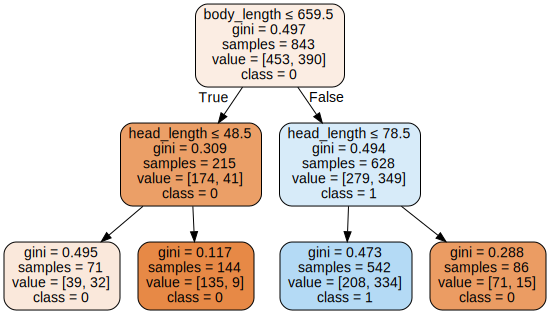

In [19]:
feature_names = list(x_trainfake) 
dot_data = export_graphviz(tree_clf, out_file = None, 
                           feature_names = feature_names, 
                           class_names = ["0", "1" ],
                           rounded = True, filled=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph 

### 4.3 Large Tree

In [20]:
tree_clf_large = DecisionTreeClassifier ()
tree_clf_large.fit (x_trainfake, y_trainfake)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

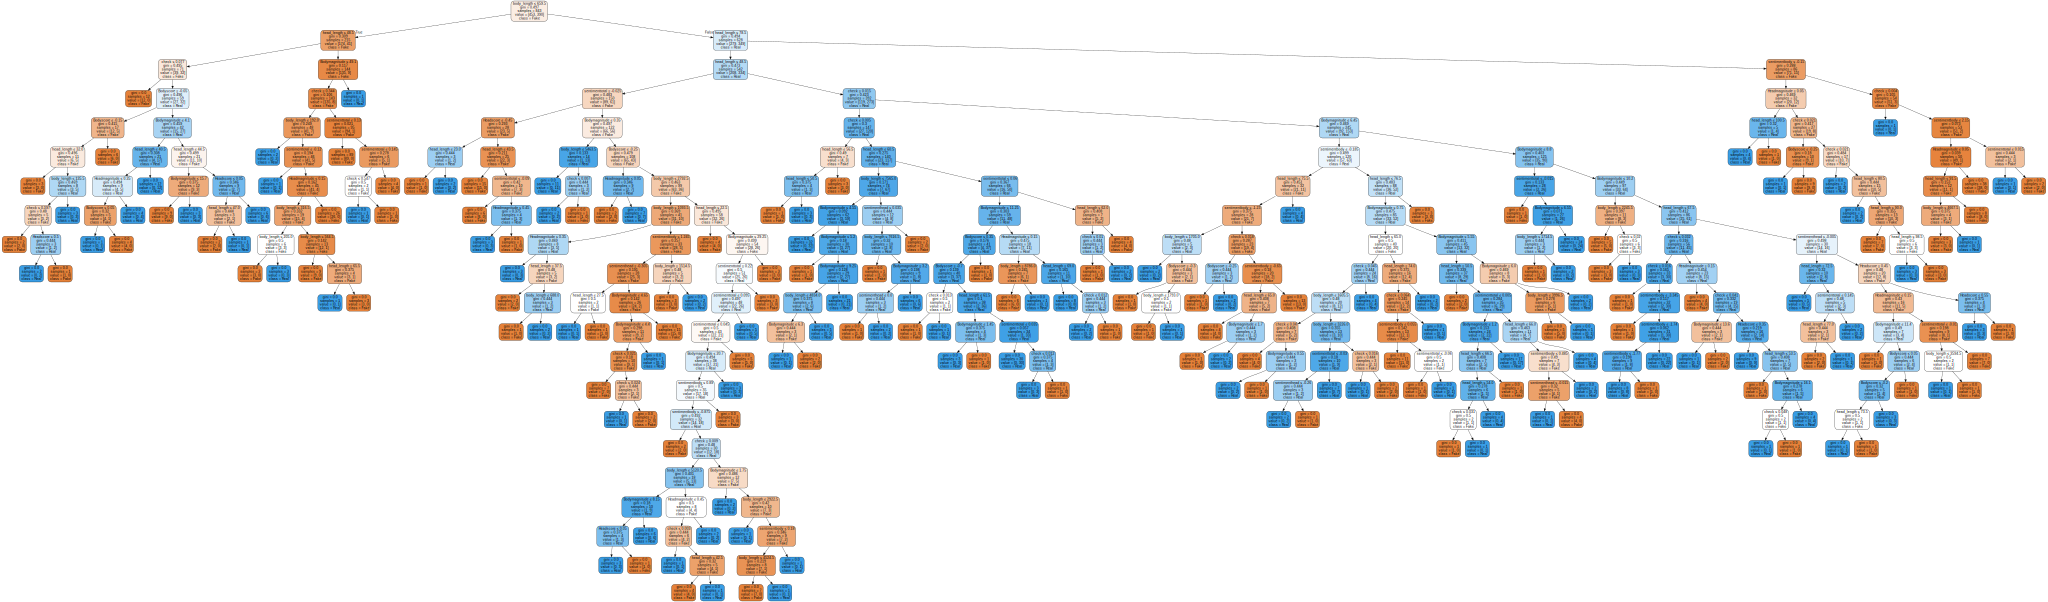

In [21]:
dot_data = export_graphviz(tree_clf_large, out_file = None, 
                           feature_names = feature_names, 
                           class_names = ["Fake", "Real" ],
                           rounded = True, filled=True, special_characters=True)
graph = graphviz.Source(dot_data ) 
graph 

In [22]:
y2_test_predict = tree_clf.predict (x_testfake)

In [23]:
conf_matrix = confusion_matrix(y_testfake, y2_test_predict)
conf_matrix

array([[ 80,  62],
       [ 21, 118]], dtype=int64)

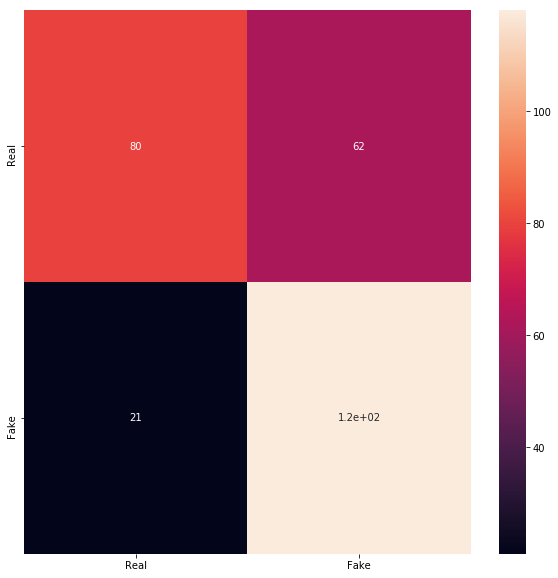

In [24]:
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ["Real","Fake"]],
                  columns = [i for i in ["Real","Fake"]])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True)

In [25]:
confusion_matrix(y_trainfake, tree_clf.predict (x_trainfake))

array([[245, 208],
       [ 56, 334]], dtype=int64)

In [26]:
y_testfake_predict = tree_clf_large.predict(x_testfake)

In [27]:
print("The recall for the large tree is ",recall_score(y_testfake, y_testfake_predict))
print("The precision for the large tree is ",precision_score(y_testfake, y_testfake_predict))

The recall for the large tree is  0.5899280575539568
The precision for the large tree is  0.7130434782608696


In [36]:
smalltreescore = tree_clf.score(x_testfake, y_testfake)

In [37]:
largetreescore = tree_clf_large.score(x_testfake, y_testfake)

# Summary So far:

In [38]:
print("The recall for the small tree is ",recall_score(y_testfake, y2_test_predict)) #small tree
print("The recall for the large tree is ",recall_score(y_testfake, y_testfake_predict))  #large tree
print("The precision for the small tree is ",precision_score(y_testfake, y2_test_predict)) #small tree
print("The precision for the large tree is ",precision_score(y_testfake, y_testfake_predict))  #large tree
print("The precision for the small tree is ",smalltreescore) #small tree
print("The precision for the large tree is ",largetreescore)  #large tree

The recall for the small tree is  0.8489208633093526
The recall for the large tree is  0.5899280575539568
The precision for the small tree is  0.6555555555555556
The precision for the large tree is  0.7130434782608696
The precision for the small tree is  0.7046263345195729
The precision for the large tree is  0.6797153024911032


Selecting Thershold for precision & Recall

In [40]:
y2_test_proba = tree_clf.predict_proba(x_testfake)
y2_test_proba[:,1]

array([0.61623616, 0.61623616, 0.61623616, 0.61623616, 0.61623616,
       0.0625    , 0.61623616, 0.0625    , 0.0625    , 0.61623616,
       0.61623616, 0.61623616, 0.61623616, 0.61623616, 0.61623616,
       0.0625    , 0.0625    , 0.61623616, 0.1744186 , 0.0625    ,
       0.61623616, 0.61623616, 0.61623616, 0.0625    , 0.61623616,
       0.61623616, 0.61623616, 0.61623616, 0.61623616, 0.0625    ,
       0.61623616, 0.1744186 , 0.61623616, 0.0625    , 0.61623616,
       0.0625    , 0.61623616, 0.61623616, 0.0625    , 0.45070423,
       0.0625    , 0.61623616, 0.61623616, 0.0625    , 0.0625    ,
       0.0625    , 0.61623616, 0.45070423, 0.45070423, 0.61623616,
       0.61623616, 0.61623616, 0.0625    , 0.61623616, 0.1744186 ,
       0.61623616, 0.45070423, 0.45070423, 0.61623616, 0.61623616,
       0.61623616, 0.1744186 , 0.61623616, 0.0625    , 0.61623616,
       0.61623616, 0.61623616, 0.0625    , 0.61623616, 0.61623616,
       0.61623616, 0.61623616, 0.61623616, 0.0625    , 0.61623

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_true = y_testfake, probas_pred = y2_test_proba[:,1])
print(" Precision = ", precisions, "\n", "Recalls = ", recalls, "\n", "Thresholds = ", thresholds)

 Precision =  [0.49466192 0.58515284 0.647343   0.65555556 1.        ] 
 Recalls =  [1.         0.96402878 0.96402878 0.84892086 0.        ] 
 Thresholds =  [0.0625     0.1744186  0.45070423 0.61623616]


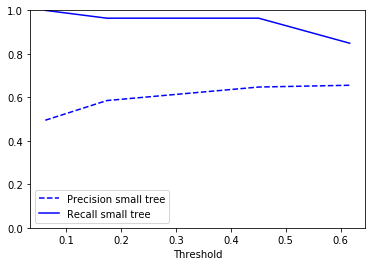

In [42]:
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds, color = "k", label = None):
    plt.plot (thresholds, precisions[:-1], color+"--", label="Precision "+label)
    plt.plot (thresholds, recalls[:-1], color+"-", label="Recall "+label)
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold( precisions, recalls, thresholds, color = "b", label="small tree")
plt.legend(loc = "best")
plt.show()

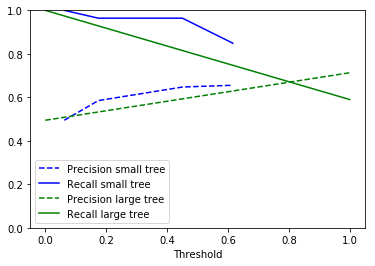

In [43]:
y_test_proba = tree_clf_large.predict_proba(x_testfake)
precisions_large, recalls_large, thresholds_large = precision_recall_curve(y_true = y_testfake, probas_pred = y_test_proba[:,1])
plot_precision_recall_vs_threshold( precisions, recalls, thresholds, color = "b", label="small tree")
plot_precision_recall_vs_threshold( precisions_large, recalls_large, thresholds_large, color = "g", label="large tree")
plt.legend(loc = "best")
plt.show()

Comparing AUC & ROC of Small & Large Tree

In [44]:
fpr, tpr, thresholds = roc_curve(y_testfake, y_test_proba[:,1])

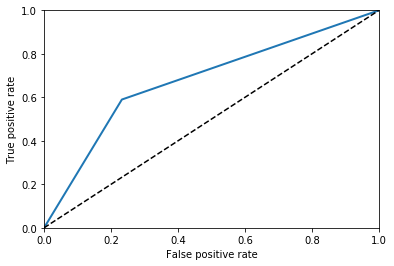

In [45]:
def plot_roc_curve (fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
plot_roc_curve (fpr, tpr, "small tree")
plt.show()

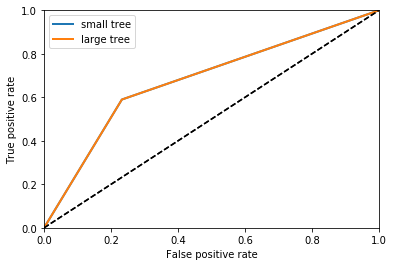

In [46]:
y_test_proba = tree_clf_large.predict_proba(x_testfake)
fpr_large, tpr_large, thresholds_large = roc_curve(y_testfake, y_test_proba[:,1])
plot_roc_curve (fpr, tpr, "small tree")
plot_roc_curve (fpr_large, tpr_large, "large tree")
plt.legend(loc = "best")
plt.show()

In [47]:
print("AUC for random guess is:   ", 0.5 )
print("AUC for the small tree is: ", roc_auc_score(y_testfake, y2_test_proba[:,1]) )
print("AUC for the large tree is: ", roc_auc_score(y_testfake, y_test_proba[:,1]) )

AUC for random guess is:    0.5
AUC for the small tree is:  0.7299371770189482
AUC for the large tree is:  0.6787668456783869


### 4.4 Random Forest

### 4.4.1 Random Forest with 0.5 Threshold

In [102]:
rnd_clf1 = RandomForestClassifier(n_estimators = 50, max_depth =6, max_features=8)
rnd_clf1.fit (x_trainfake, y_trainfake)
y_pred_rf = rnd_clf1.predict(x_testfake)

In [103]:
confusion_matrix(y_testfake, y_pred_rf)

array([[102,  40],
       [ 24, 115]], dtype=int64)

In [104]:
recall_score(y_testfake, y_pred_rf)

0.8273381294964028

In [105]:
precision_score(y_testfake, y_pred_rf)

0.7419354838709677

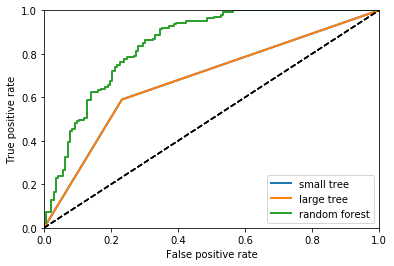

In [106]:
y_rf_proba = rnd_clf1.predict_proba(x_testfake)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_testfake, y_rf_proba[:,1])
plot_roc_curve (fpr, tpr, "small tree")
plot_roc_curve (fpr_large, tpr_large, "large tree")
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plt.legend(loc = "best")
plt.show()


In [107]:
roc_auc_score(y_testfake, y_rf_proba[:,1])

0.8466409970615058

### 4.4.2 Random Forst with 1:2 Threshold

In [108]:
rnd_clf = RandomForestClassifier(n_estimators = 50, max_depth =6, max_features=8,class_weight={1:3})
rnd_clf.fit (x_trainfake, y_trainfake)
y_pred_rf = rnd_clf.predict(x_testfake)

In [109]:
confusion_matrix(y_testfake, y_pred_rf)

array([[ 80,  62],
       [  9, 130]], dtype=int64)

In [110]:
roc_test_recall = recall_score(y_testfake, y_pred_rf)
roc_test_recall

0.935251798561151

In [111]:
roc_test_precision = precision_score(y_testfake, y_pred_rf)
roc_test_precision

0.6770833333333334

In [112]:
roc_test_score = roc_auc_score(y_testfake, y_rf_proba[:,1])
roc_test_score

0.8466409970615058

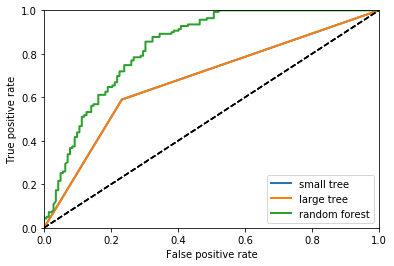

In [113]:
y_rf_proba = rnd_clf.predict_proba(x_testfake)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_testfake, y_rf_proba[:,1])
plot_roc_curve (fpr, tpr, "small tree")
plot_roc_curve (fpr_large, tpr_large, "large tree")
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plt.legend(loc = "best")
plt.show()

### 4.4.3 Using RF on Train Data for Comparison

In [114]:
rnd_clf = RandomForestClassifier(n_estimators = 50, max_depth =6, max_features=8,class_weight={1:3})
rnd_clf.fit (x_trainfake, y_trainfake)
y_pred_rf = rnd_clf.predict(x_trainfake)

In [115]:
y_pred_rf2 = rnd_clf.predict(x_trainfake)

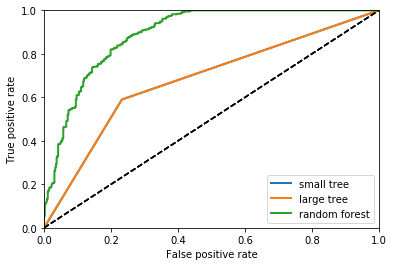

In [116]:
y_rf_proba = rnd_clf.predict_proba(x_trainfake)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_trainfake, y_rf_proba[:,1])
plot_roc_curve (fpr, tpr, "small tree")
plot_roc_curve (fpr_large, tpr_large, "large tree")
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plt.legend(loc = "best")
plt.show()

In [117]:
confusion_matrix(y_trainfake, y_pred_rf2)

array([[266, 187],
       [  4, 386]], dtype=int64)

In [118]:
roc_train_recall = recall_score(y_trainfake, y_pred_rf2)
roc_train_recall

0.9897435897435898

In [119]:
roc_train_precision = precision_score(y_trainfake, y_pred_rf2)
roc_train_precision

0.6736474694589878

In [120]:
roc_train_score = roc_auc_score(y_trainfake, y_rf_proba[:,1])
roc_train_score

0.8905954604630101

In [121]:
print("For Training Data: Our ROC AUC Score:",roc_train_score,"Train Precision:",roc_train_precision,"Train Recall:",roc_train_recall,
     "For Test Data: Our ROC AUC Score:",roc_test_score,"Test Precision:",roc_test_precision,"Test Recall:",roc_test_recall)

For Training Data: Our ROC AUC Score: 0.8905954604630101 Train Precision: 0.6736474694589878 Train Recall: 0.9897435897435898 For Test Data: Our ROC AUC Score: 0.8466409970615058 Test Precision: 0.6770833333333334 Test Recall: 0.935251798561151


We can see there is a little-none overfitting and overall the RF Score will be much better with the 1:2 threshold.

We can also see our score is pretty good for Recall - which is what we want!

### 4.5 GBM

In [123]:
clf_gb = ensemble.GradientBoostingClassifier(n_estimators=40, max_features=8,max_depth=6)
clf_gb.fit(x_trainfake, y_trainfake)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [124]:
y_pred_gb = clf_gb.predict(x_testfake)

In [125]:
confusion_matrix(y_testfake, y_pred_gb)

array([[107,  35],
       [ 35, 104]], dtype=int64)

In [126]:
recall_score(y_testfake, y_pred_gb)

0.7482014388489209

In [127]:
precision_score(y_testfake, y_pred_gb)

0.7482014388489209

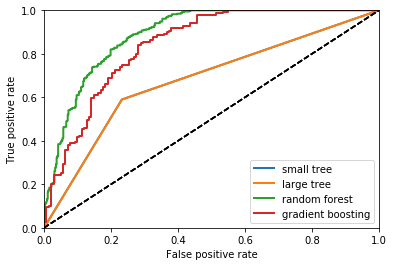

In [128]:
y_gb_proba = clf_gb.predict_proba(x_testfake)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_testfake, y_gb_proba[:,1])

plot_roc_curve (fpr, tpr, "small tree")
plot_roc_curve (fpr_large, tpr_large, "large tree")
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plot_roc_curve (fpr_gb, tpr_gb, "gradient boosting")
plt.legend(loc = "best")
plt.show()

In [129]:
roc_auc_score(y_testfake, y_gb_proba[:,1])

0.8425372378153815

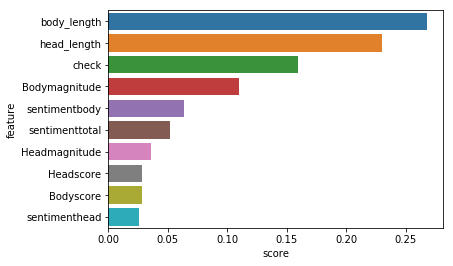

In [130]:
feature_score = clf_gb.feature_importances_
feature_names = list(x_testfake)
df_feature_score = pd.DataFrame(data=feature_names, columns=["feature"])
df_feature_score["score"]= feature_score
df_feature_score = df_feature_score.sort_values(by=['score'], ascending=False)
sns.barplot(y="feature", x="score", data=df_feature_score)

## B2B Model - Helping Trump Out

### 2.0.1 Trump Data Preprocessing

In [153]:
df_fake_trump = faketrain_df[faketrain_df['Headline'].str.contains("trump")]
df_fake_not_trump = faketrain_df[faketrain_df['Headline'].str.contains("trump")==False]
df_fake_not_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 1 to 1498
Data columns (total 44 columns):
index             1332 non-null object
Body              1332 non-null object
Headline          1332 non-null object
Label             1332 non-null int64
Site              1332 non-null object
head_length       1332 non-null int64
body_length       1332 non-null int64
HeadbodyRatio     1332 non-null float64
trump             1332 non-null int32
hillary           1332 non-null int32
clinton           1332 non-null int32
election          1332 non-null int32
video             1332 non-null int32
comment           1332 non-null int32
news              1332 non-null int32
america           1332 non-null int32
world             1332 non-null int32
obama             1332 non-null int32
donald            1332 non-null int32
russia            1332 non-null int32
breaking          1332 non-null int32
week              1332 non-null int32
emails            1332 non-null int32
says         

In [154]:
df_fortrain_tr = df_fake_trump
df_fortrain_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 2 to 1495
Data columns (total 44 columns):
index             166 non-null object
Body              166 non-null object
Headline          166 non-null object
Label             166 non-null int64
Site              166 non-null object
head_length       166 non-null int64
body_length       166 non-null int64
HeadbodyRatio     166 non-null float64
trump             166 non-null int32
hillary           166 non-null int32
clinton           166 non-null int32
election          166 non-null int32
video             166 non-null int32
comment           166 non-null int32
news              166 non-null int32
america           166 non-null int32
world             166 non-null int32
obama             166 non-null int32
donald            166 non-null int32
russia            166 non-null int32
breaking          166 non-null int32
week              166 non-null int32
emails            166 non-null int32
says              166 non-null int32


In [156]:
# Dropping Site, Body, Headline, URLs columns from our Database
df_fortrain_tr = df_fake_trump.drop(columns=["Headline","Body","Site","index"])
df_fortrain_tr
train_df_tr, test_df_tr= train_test_split (df_fortrain_tr, test_size = 0.2, random_state=7)

In [157]:
train_df_tr = df_fake_not_trump.drop(columns=["Headline","Body","Site","index"])
test_df_tr = df_fortrain_tr

In [167]:
y_trump = train_df_tr["Label"]
X_trump = train_df_tr.drop("Label", axis = 1)
x_test = test_df_tr.drop("Label", axis = 1)
y_test = test_df_tr["Label"]

In [169]:
x_test_tr = x_test
y_test_tr = y_test

In [166]:
x_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 2 to 1495
Data columns (total 39 columns):
head_length       166 non-null int64
body_length       166 non-null int64
HeadbodyRatio     166 non-null float64
trump             166 non-null int32
hillary           166 non-null int32
clinton           166 non-null int32
election          166 non-null int32
video             166 non-null int32
comment           166 non-null int32
news              166 non-null int32
america           166 non-null int32
world             166 non-null int32
obama             166 non-null int32
donald            166 non-null int32
russia            166 non-null int32
breaking          166 non-null int32
week              166 non-null int32
emails            166 non-null int32
says              166 non-null int32
wikileaks         166 non-null int32
police            166 non-null int32
president         166 non-null int32
campaign          166 non-null int32
2017              166 non-null int32
u.s.

Trying RF with trump

In [173]:
rnd_clf = RandomForestClassifier(n_estimators = 30, max_depth =5, max_features=8,class_weight={1:2})
rnd_clf.fit (X_trump, y_trump)
y_pred_rf = rnd_clf.predict(x_test_tr)

In [174]:
y_pred_rf_tr = rnd_clf.predict(x_test_tr)

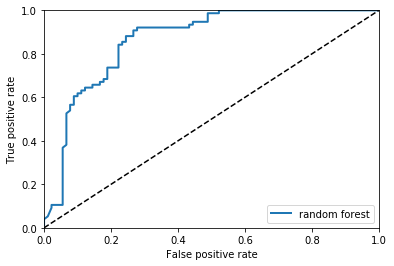

In [175]:
y_rf_proba_tr = rnd_clf.predict_proba(x_test_tr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_tr, y_rf_proba_tr[:,1])
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plt.legend(loc = "best")
plt.show()

In [176]:
confusion_matrix(y_test_tr, y_pred_rf_tr)

array([[60, 30],
       [ 6, 70]], dtype=int64)

In [177]:
roc_test_recall_tr = recall_score(y_test_tr, y_pred_rf_tr)
roc_test_recall_tr

0.9210526315789473

In [178]:
roc_test_precision_tr = precision_score(y_test_tr, y_pred_rf_tr)
roc_test_precision_tr

0.7

In [179]:
roc_test_score_tr = roc_auc_score(y_test_tr, y_rf_proba_tr[:,1])
roc_test_score_tr

0.8653508771929825

Comparing with Train Data

In [184]:
rnd_clf = RandomForestClassifier(n_estimators = 40, max_depth =5, max_features=8,class_weight={1:2})
rnd_clf.fit (X_trump, y_trump)
y_pred_rf = rnd_clf.predict(X_trump)

In [185]:
y_pred_rf_tr = rnd_clf.predict(X_trump)

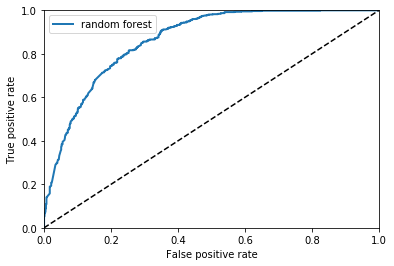

In [186]:
y_rf_proba_tr = rnd_clf.predict_proba(X_trump)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_trump, y_rf_proba_tr[:,1])
plot_roc_curve (fpr_rf, tpr_rf, "random forest")
plt.legend(loc = "best")
plt.show()

In [188]:
confusion_matrix(y_trump, y_pred_rf_tr)

array([[359, 346],
       [ 13, 614]], dtype=int64)

In [189]:
roc_train_recall_tr = recall_score(y_trump, y_pred_rf_tr)
roc_train_recall_tr

0.9792663476874003

In [190]:
roc_train_precision_tr = precision_score(y_trump, y_pred_rf_tr)
roc_train_precision_tr

0.6395833333333333

In [191]:
roc_train_score_tr = roc_auc_score(y_trump, y_rf_proba_tr[:,1])
roc_train_score_tr

0.8636725598651691

In [192]:
print("For Training Data: Our ROC AUC Score:",roc_train_score_tr,"Test Precision:",roc_train_precision_tr,"Test Recall:",roc_train_recall_tr)
print("For Test Data: Our ROC AUC Score:",roc_test_score_tr,"Test Precision:",roc_test_precision_tr,"Test Recall:",roc_test_recall_tr)

For Training Data: Our ROC AUC Score: 0.8636725598651691 Test Precision: 0.6395833333333333 Test Recall: 0.9792663476874003
For Test Data: Our ROC AUC Score: 0.8653508771929825 Test Precision: 0.7 Test Recall: 0.9210526315789473
